In [6]:
import ollama

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer
from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *
from reco_systems.llm import *

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

from IPython.core.display import display_html

import textwrap # to avoid scrolling on long strings in jupyter
#%load_ext autoreload
#%autoreload 2
%matplotlib inline


In [2]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()

rev_filter = rev_filter.assign(index=rev_filter.index)
rev_filter["Length"] = rev_filter["Comment body"].str.split().apply(len)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [3]:
lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv", index_col=0)
lemmas = lemmas[~lemmas["Lemma"].isna()]
comment_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().dropna(subset=["Lemma"])
comment_lemmatized = comment_lemmatized.merge(rev_filter[["Game id", "User id", "index"]], left_on="Comment line", right_on="index").rename(columns={"Lemma":"Comment body"})

In [4]:
# Embeddings on all games descriptions
# games_filter = jeux_clean[jeux_clean["Game id"].isin(rev_filter["Game id"])].sort_values("Game id")[["Game id", "Description"]]

# from FlagEmbedding import BGEM3FlagModel

# model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

# descriptions = games_filter["Description"].tolist()

# # Batch encode
# encoded = model.encode(
#     descriptions,
#     batch_size=12,         # now this matters
#     max_length=6144,       # truncate long ones
#     return_dense=True,     # default is True, but explicit is good
# )

### Summarizing game/user comments 

#### Number of reviews per user

In [7]:
users_count = rev_filter.groupby("User id").agg(count=('Game id', 'count'), mean=('Rating', 'mean')).reset_index().sort_values(by="mean").head(30)
games_count = rev_filter.groupby("Game id").agg(count=('User id', 'count'), mean=('Rating', 'mean')).reset_index().sort_values(by="mean").head(30)

users_styler = users_count.style.set_table_attributes("style='display:inline'").set_caption('Users count reviews, mean rating')
games_styler = games_count.style.set_table_attributes("style='display:inline'").set_caption('Users count reviews, mean rating')
    
display_html(users_styler._repr_html_()+games_styler._repr_html_(), raw=True)

,User id,count,mean
491,1474,13,3.500000
1281,3683,43,4.139535
432,1207,41,4.141463
1714,5625,10,4.160000
1827,6888,12,4.500000
1664,5196,12,4.500000
66,111,119,4.554622
1735,6078,10,4.600000
1569,4730,11,4.727273
274,614,39,4.782051


### Game's comments

**Game with 140 reviews and mean rating : 6.74**

In [9]:
game = 4342
game_comments = rev_filter[rev_filter["Game id"] == game]
game_comments = game_comments.assign(Batch=assign_batch_number(game_comments, 2300))
game_comments_batched = game_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(game_comments["Comment body"]))
response = call_model_by_batch(game_comments_batched, "game")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Nb words: 9350
5
Nb tokens: 7933
Le jeu de cochon est une boîte de jeux qui met deux petits cochons en plastique à l'intérieur. Le
principe du jeu consiste à lancer les deux cochons sur une table et à compter les points
correspondants aux positions où ils retombent. Voici quelques aspects clés du jeu :

*   **Simplicité et accessibilité** : le jeu est simple à expliquer et à comprendre, ce qui en fait
un choix idéal pour jouer avec des personnes de toutes âges et de tous niveaux.
*   **Transportabilité et flexibilité**: On peut facilement emporter le jeu dans son sac, donc il
est très portable.

Il existe également quelques points à prendre en compte lors du jeu :

*   **Hasard** : Le jeu repose fortement sur la chance, ce qui peut être frustrant pour ceux qui ont
de la difficulté à s'adapter.


**Game with 93 reviews and mean ratings : 3.27**

In [10]:
game = 4360
game_comments = rev_filter[rev_filter["Game id"] == game]
game_comments = game_comments.assign(Batch=assign_batch_number(game_comments, 2300))
game_comments_batched = game_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(game_comments["Comment body"]))
response = call_model_by_batch(game_comments_batched, "game")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Nb words: 5086
3
Nb tokens: 4542
Le jeu de l'oie est un classique qui a été populaire dans les années 60, 70 et 80. Il s'agit d'un
jeu de hasard où les joueurs lancent des dés pour déplacer leur pion vers le but du jeu. Le jeu est
souvent critiqué pour son manque de stratégie et son caractère aléatoire, ce qui peut rendre la
partie très rapide mais également très ennuyeuse.

Les joueurs ont noté que le jeu est idéal pour les enfants qui apprennent à compter et à gagner ou
perdre, car il leur enseigne à connaître les chiffres et à comprendre l'idée de succès et d'échec.
Cependant, pour les adultes, le jeu peut être considéré comme trop simple et manquant de complexité.

Les jeux de société ont évolué depuis les années 60, et les joueurs préfèrent maintenant des jeux
plus stratégiques et interactifs. Le Monopoly, par exemple, est considéré comme un jeu plus
intéressant que le jeu de l'oie.

Cependant, le jeu de l'oie reste un classique qui est toujours populaire chez les enfants et peut


### Comments embeddings per cluster

In [11]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]

NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 

games_clusters = pd.DataFrame(data={"Game id":np.sort(games_ids), "Cluster":kmeans.labels_})

#### Embeddings on comments per clusters
Only comments that have $10$ to $300$ words are selected

In [207]:
comment_real = rev_filter[(rev_filter["Length"] >= 10) & (rev_filter["Length"] <= 300)][["User id", "Game id", "index", "Comment body"]]

# comment_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().dropna(subset=["Lemma"])
# comment_lemmatized = comment_lemmatized.merge(rev_filter[["Game id", "User id"]], left_on="Comment line", right_index=True)

comment_lemmatized = comment_lemmatized.merge(comment_real[["index"]], left_on="Comment line", right_on="index").sort_values("Comment line")
comment_real = comment_real.merge(comment_lemmatized[["Comment line"]], right_on="Comment line", left_on="index").sort_values("index")

comment_lemmatized.shape, comment_real.shape

((89508, 6), (89508, 5))

In [208]:
desc_lemmas = pd.read_csv("../generated_data/desc_lemmas.csv", index_col=0)

# Errors in lemmatization
desc_lemmas.loc[(desc_lemmas["Lemma"] == "poindre") & (desc_lemmas["Tokens"] == "points"), ["Lemma", "POS"]] = ["point", "NOM"] 
desc_lemmas.loc[(desc_lemmas["Lemma"] == "poindre") & (desc_lemmas["Tokens"] == "poins"), ["Lemma", "POS"]] = ["poin", "NOM"] 
desc_lemmas.loc[(desc_lemmas["Lemma"] == "poindre") & (desc_lemmas["Tokens"] == "pointes"), ["Lemma", "POS"]] = ["pointes", "NOM"] 

desc_lemmatized = desc_lemmas.groupby("Game id")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma":"Description"})

desc_embeddings = pd.read_parquet("../generated_data/descriptions_embeddings.parquet")

# Delete games that have no description
desc_embeddings = desc_embeddings[~desc_embeddings["Description"].str.contains("Aucune description")]
desc_embeddings["Length"] = desc_embeddings["Description"].str.split().apply(len)

# Find intersection
desc_lemmatized = desc_lemmatized[desc_lemmatized["Game id"].isin(desc_embeddings["Game id"])]
desc_lemmatized.shape, desc_embeddings.shape

((2529, 2), (2529, 4))

### TF-IDF is tried -> works bad

In [11]:
# bigrams = BigramCollocationFinder.from_documents(desc_lemmatized["Description"].str.split().tolist())
# bigrams_freq = bigrams.score_ngrams(BigramAssocMeasures.raw_freq)

# bigrams_df = pd.DataFrame(data=[list(info) for info in bigrams_freq])

# bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
# bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})

# bigrams_df = bigrams_df[~bigrams_df["Lemma"].str.contains("joueur")]

# sns.set_theme(rc={"figure.figsize":(7, 15)})
# sns.barplot(data=bigrams_df.sort_values("Freq").tail(80), x="Freq", y="Lemma")

In [ ]:
# count = desc_lemmas["Lemma"].value_counts().reset_index().sort_values(by="count", ascending=False)
# corpus = count[count["count"] >= 3]["Lemma"].values
# desc_lemmas = desc_lemmas[desc_lemmas["Lemma"].isin(corpus)]

# # desc_lemmas = desc_lemmas[desc_lemmas["Game id"].isin(count.loc[count["Lemma"] >= 10, "Game id"])]

# desc_lemmatized = desc_lemmas.groupby("Game id")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma":"Description"})
# desc_lemmatized.shape

(2614, 2)

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(2, 2)) # tfidf on bigrams
# desc_tfidf = vectorizer.fit_transform(desc_lemmatized["Description"])

# # Convert back to description
# games, bigrams = desc_tfidf.nonzero()
# tfidf = desc_tfidf.data
# ptr = desc_tfidf.indptr
# corpus = vectorizer.get_feature_names_out()

# threshold = 0.1

# bigrams_df = pd.DataFrame(data={"index":games, 
#                                 "Bigrams":[corpus[b] for b in bigrams], 
#                                 "tdidf":tfidf})

# games_map = pd.DataFrame(data={"index": np.arange(0, desc_lemmatized.shape[0]), 
#                                "Game id" : desc_lemmatized["Game id"]})

# bigrams_df = bigrams_df[bigrams_df["tdidf"] > threshold]
# games_bigrams = bigrams_df.merge(games_map, on="index")
# games_filter = games_bigrams.groupby("Game id")["Bigrams"].apply(" ".join).reset_index().rename(columns={"Bigrams":"Description"})
# games_filter
# games_filter_real = jeux_clean[jeux_clean["Game id"].isin(games_filter["Game id"])][["Game id", "Description"]]

In [209]:
def find_represent_comment(cluster:int, games_clusters:pd.DataFrame, text_lemmatized:pd.DataFrame, 
                           text_real_embeddings:pd.DataFrame, column_name:str):
    # all comments per cluster
    games_in_cluster = games_clusters[games_clusters["Cluster"] == cluster]
    text_real_embeddings = text_real_embeddings[text_real_embeddings["Game id"].isin(games_in_cluster["Game id"])].sort_values("Game id")
    text_lemmatized = text_lemmatized[text_lemmatized["Game id"].isin(games_in_cluster["Game id"])].sort_values("Game id")

    #print(real_text, text_lemmatized)
    print("Nb texts :", text_real_embeddings.shape[0], text_lemmatized.shape[0])

    # Extract embeddings
    embeddings = np.array(text_real_embeddings["Embedding"].tolist())
    
    # Find mean comment
    mean_text = embeddings.mean(axis=0) 

    # Find closest existing comment 
    dist = euclidean_distances(mean_text.reshape(1, -1), embeddings)
    #print(dist.shape)
    return text_real_embeddings, text_lemmatized, embeddings, dist.flatten()

def plot_bigrams(text_selected, ax=None):
    bigrams = BigramCollocationFinder.from_documents(text_selected.str.split().tolist())
    bigrams_freq = bigrams.score_ngrams(BigramAssocMeasures.raw_freq)

    bigrams_df = pd.DataFrame(data=[list(info) for info in bigrams_freq])

    bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
    bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})

    if ax is not None:
        ax = sns.barplot(data=bigrams_df.sort_values(by="Freq", ascending=False).head(40), x="Freq", y="Lemma", ax=ax)
    else:
        sns.set_theme(rc={"figure.figsize":(15, 6)})
        ax = sns.barplot(data=bigrams_df.sort_values(by="Freq", ascending=False).head(90), y="Freq", x="Lemma")
        ax.set_xticks(ax.get_xticks())  # Explicitly set tick locations
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value
        ax.set_title(f"Nb texts selected : {text_selected.size}")
    
    return bigrams_df
def plot_bigrams_both(comments_selected, desc_selected):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    plot_bigrams(comments_selected, ax1)
    ax1.set_title("Comments bigrams")

    plot_bigrams(desc_selected, ax2)
    ax2.set_title("Descriptions bigrams")

    plt.tight_layout()

def describe_cluster(cluster, perc_desc, perc_comments, llm_k, games_clusters, desc_lemmatized, desc_real,
                     comments_lemmatized, comments_real, comments=False):

    real_desc_cluster, lemmas_desc_cluster, embeddings, dist_desc = find_represent_comment(cluster, games_clusters,
                                                                                      desc_lemmatized, desc_real, "Description")
    print("Description embeddings completed")

    # Treat descriptions
    dist_min_desc = np.min(dist_desc)
    closest_desc = np.argwhere(dist_desc <= dist_min_desc * perc_desc).flatten()
    #closest_desc = np.argpartition(dist_desc.flatten(), 10)[:10]
    
    # Treat comments
    if comments:
        real_comments_cluster, lemmas_comments_cluster, embeddings, dist_comments = find_represent_comment(cluster, games_clusters,
                                                                             comments_lemmatized, comments_real, "Comment body")
        print("Comments embeddings completed")

        dist_min_comments = np.min(dist_comments)
        closest_comments = np.argwhere(dist_comments <= dist_min_comments * perc_comments).flatten()

        print('\033[1m' + "CENTER COMMENT :" + '\033[0m', textwrap.fill(real_comments_cluster.iloc[np.argmin(dist_comments)]["Comment body"], width=100))

        print(real_desc_cluster.shape, real_comments_cluster.shape, dist_desc.shape, dist_comments.shape)
    desc_for_llm = real_desc_cluster.iloc[np.argpartition(dist_desc.flatten(), llm_k)[:llm_k]]
    if comments:
        plot_bigrams_both(lemmas_comments_cluster.iloc[closest_comments]["Comment body"], lemmas_desc_cluster.iloc[closest_desc]["Description"])
    else:
        print("Distance descriptions : ", np.sort(dist_desc)[:llm_k])
        ret2 = plot_bigrams(lemmas_desc_cluster.iloc[closest_desc]["Description"])

    print('\033[1m' + "CENTER DESC :" + '\033[0m', textwrap.fill(real_desc_cluster.iloc[np.argmin(dist_desc)]["Description"], width=100), "\n")

    return desc_for_llm, ret2

def plot_bigrams_tfidf(games_bigrams, games):
    games_bigrams = games_bigrams[games_bigrams["Game id"].isin(games)]

    bigrams_df = games_bigrams.groupby("Bigrams")["Game id"].nunique().reset_index(name="Freq")
    # bigrams_games_count = games_bigrams.groupby("Bigrams")["Game id"].nunique().reset_index(name="Games Appeared")

    # bigrams_df = pd.merge(bigrams_freq, bigrams_games_count, on="Bigrams")

    # bigrams_df["Freq"] = bigrams_df["Freq"]


    sns.set_theme(rc={"figure.figsize":(15, 6)})
    ax = sns.barplot(data=bigrams_df.sort_values(by="Freq", ascending=False).head(100), y="Freq", x="Bigrams")
    ax.set_xticks(ax.get_xticks())  # Explicitly set tick locations
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value

#### Cluster 5

**Thème commun : La conquête et le pouvoir**

Unigrams/Bigrams:
- acquerir suprémacie
- phase attaquer
- pétrole
- rail
- proteger monde
- bombe atomique
- six superpuissance

**Targeted public : adults**

In [200]:
desc_embeddings["Embedding"].iloc[0].shape

(1024,)

Nb texts : 81 81
Description embeddings completed
Distance descriptions :  [0.59650852 0.62894565 0.63256348 0.63992386 0.64373438 0.64399747
 0.64482556 0.65380831 0.66307569 0.66413046]
CENTER DESC : Déroulement du jeu Chaque joueur possède son propre parcours, que sa figurine doit réaliser. Pour
pouvoir se frayer un chemin, les joueurs doivent au préalable rassembler les cartes appropriées. Ce
n’est pas vraiment si simple, car tous fouillent en même temps dans les cartes qui sont face
cachées. Ce qui peut être utilisé est conservé. Les autres cartes sont rejetées face visibles, et
les adversaires peuvent s’en emparer. Seul celui qui rassemble les cartes dans l’ordre correct,
progressera sur son parcours. Fin de partie Celui qui après plusieurs étapes atteint en premier son
objectif, gagne la course. Dans la version experte, celui qui, après plusieurs courses, obtient le
plus de points, est le gagnant. Matériel du jeu 28 cartes Parcours (sur chacune est représenté 18
types de terrain

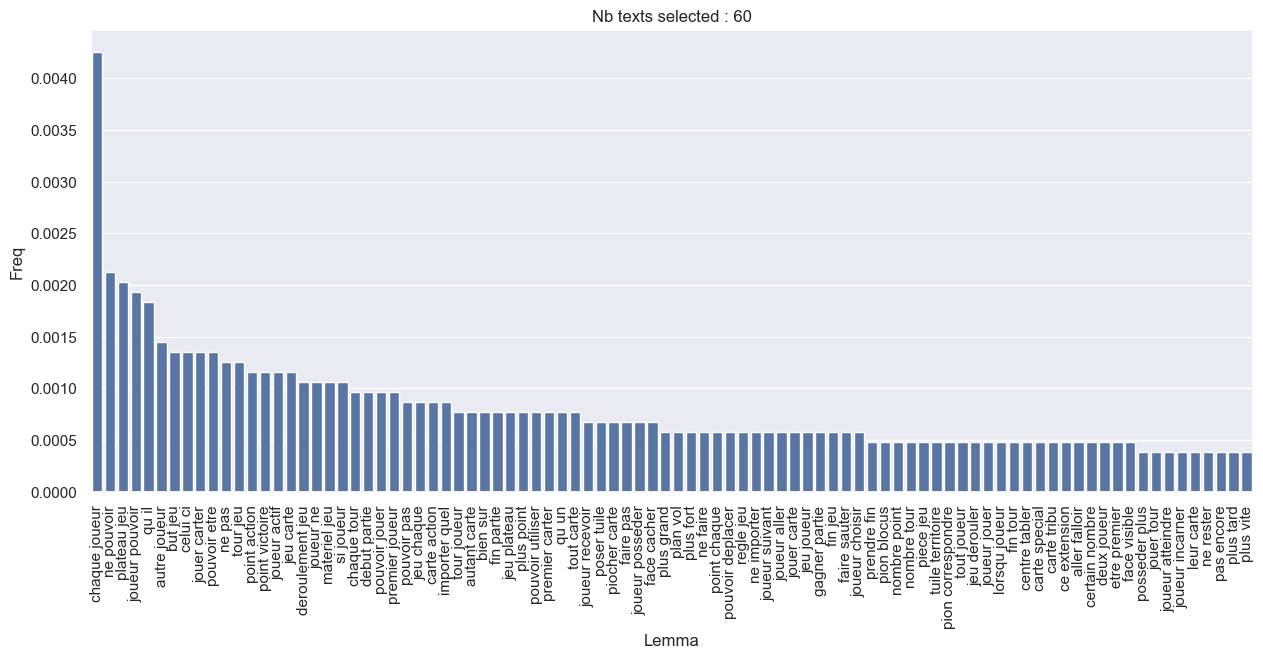

In [192]:
desc_llm, bigrams = describe_cluster(5, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
bigrams.sort_values("Freq", ascending=False).iloc[100:150]
lemmas = ["petroler minerai", "aventurier rail", "carte armee", "conquerir planete", "phase commerce", "personnage secret",
          "bataille epique", "jeu codificateur", "six superpuissance", "prendre possession"]

df = bigrams[bigrams["Lemma"].isin(lemmas)]
# df
# cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
# cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

# print("Nb words:", calc_nb_words(cluster_desc["Description"]))
# response=call_model_by_batch(cluster_desc_batched, "descriptions")
# print("Nb tokens sent :", response["prompt_eval_count"])
# print(response["message"]["content"])

### Cluster 0

**Focus sur l'expansion, la construction et la gestion de ressources**

Unigrams/bigrams
- tuile | alimenter maison 
- alimenter eau
- statuette
- coût construction

**Public**
- Jeunes, famille

Nb texts : 60 60
Description embeddings completed
Distance descriptions :  [0.61588773 0.63007131 0.63578792 0.64527644 0.65423934 0.65870592
 0.65902103 0.66037549 0.66207836 0.6656628 ]
CENTER DESC : Les joueurs débutent avec une main de 5 cartes. Ils joueront à tour de rôle, dans le sens des
aiguilles d'une montre. Durant son tour un joueur : - Pioche deux cartes. - Joue autant de cartes de
sa main qu'il le souhaite (cartes territoire, adversaire, épreuve ou carte spéciale.) - Affronte un
adversaire déjà en jeu ou tente de conquérir un territoire adverse. - Joue des cartes de renfort sur
des cartes "adversaire" ou "territoire". Une fois son tour terminé, il défausse des cartes de sa
main pour revenir à 5 cartes s'il lui en reste plus. S'il atteint 15 points de prestige, il peut
affronter Maletar. S'il le bat, il remporte la partie. Dans le cas contraire, il perd une carte de
prestige (et donc des points) et la partie suit son cours ... 



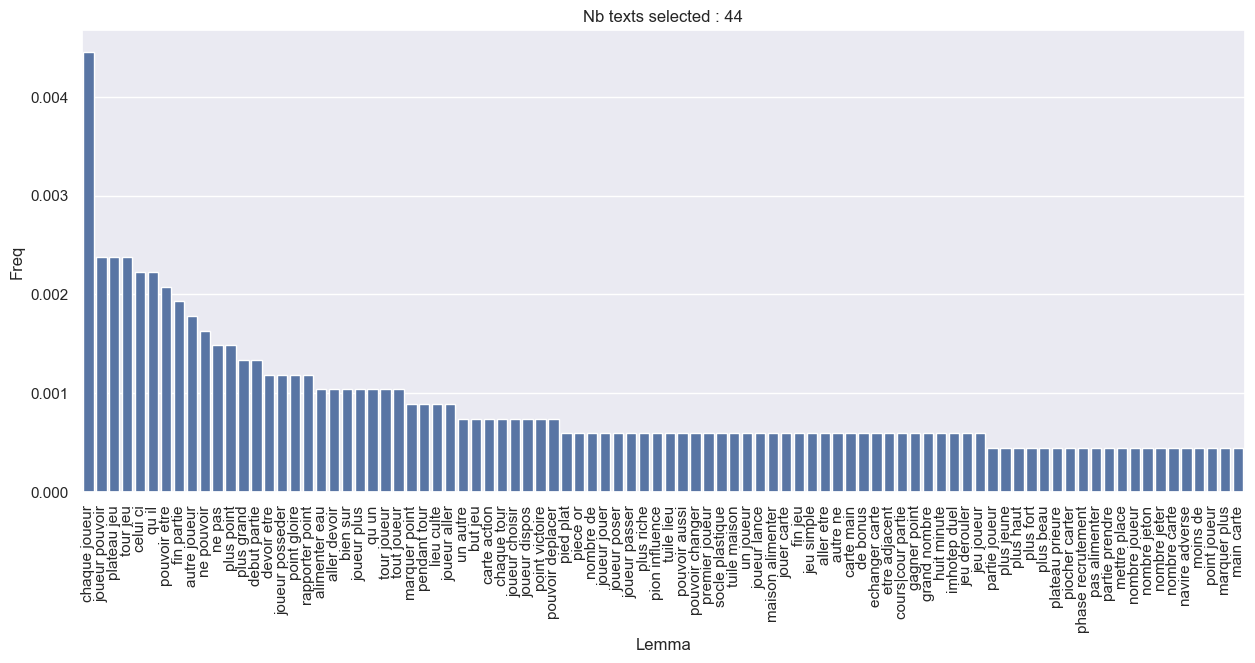

In [193]:
desc_llm, bigrams = describe_cluster(0, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
 
lemmas = ["alimenter eau", "lieu culte", "tuile maison", "maison alimenter", "navire adverse",
            "statuette dieu", "case empire", "cout construction", "lieu vente", "ville region"]
df = pd.concat([df, bigrams[bigrams["Lemma"].isin(lemmas)]])
# df = pd.concat([df, desc_llm[desc_llm["Lemma"].isin(bigrams)]])
# df
#print("Games selected", cluster_desc.shape[0])
# cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
# cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

# print("Nb words:", calc_nb_words(cluster_desc["Description"]))
# response=call_model_by_batch(cluster_desc_batched, "descriptions")
# print(response["message"]["content"])

### Cluster 1

**Themes**
- Collection des ressources (trésors), exploration

Nb texts : 73 73
Description embeddings completed
Distance descriptions :  [0.61401801 0.6155218  0.62864069 0.63866333 0.6488714  0.66116504
 0.66874755 0.67036349 0.67329624 0.67501873]
CENTER DESC : But du jeu : Pour gagner, il faut se débarrasser de toutes ses cartes ... Au départ on distribue 5
cartes à chaque joueur Vous avez le droit de ne bouger qu'un batonnet pour pouvoir vous défausser
d'une de vos cartes (et ainsi en reproduire le schéma), sinon vous passez votre tour et vous
repiochez une carte. Matériel du jeu - 55 cartes - 5 batonnets 



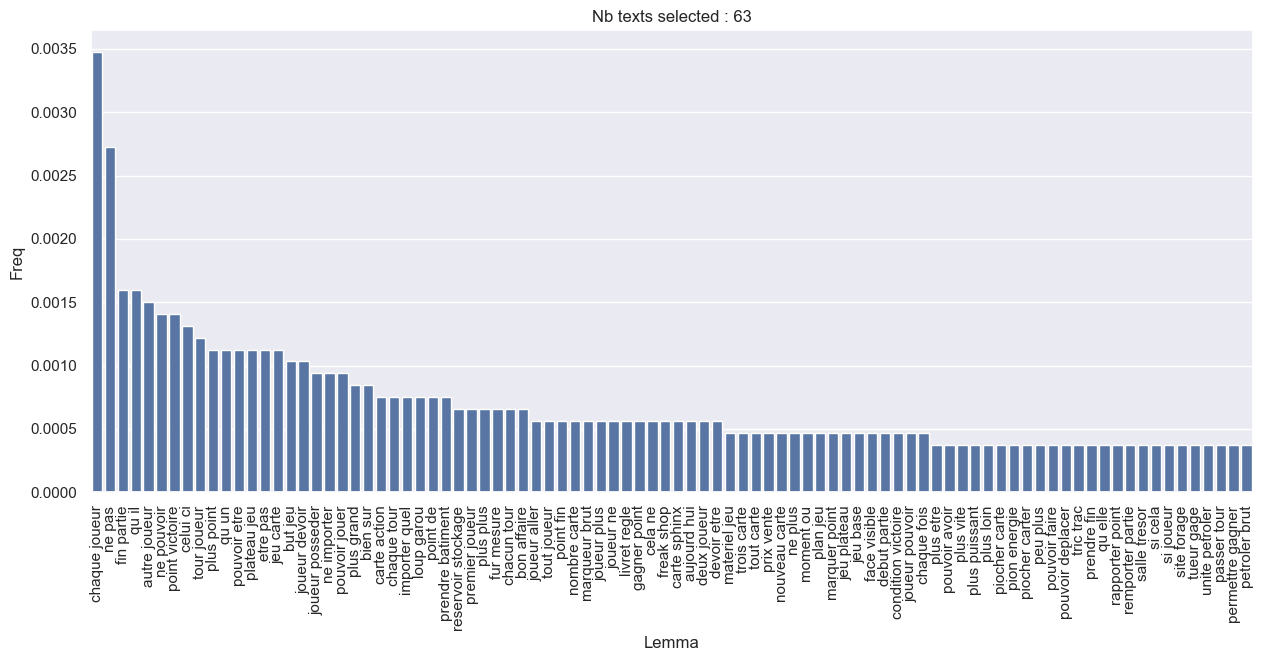

In [194]:
desc_llm, bigrams = describe_cluster(1, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
lemmas=["prendre batiment", "reservoir stockage", "carte sphinx", "carte porcelaine", "prix vente", "salle tresor", 
           "tueur gage", "carte marchandise", "falloir attraper", "relic runners"]
df = pd.concat([df, bigrams[bigrams["Lemma"].isin(lemmas)]])

# cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
# print("Games selected", cluster_desc.shape[0])
# cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

# print("Nb words:", calc_nb_words(cluster_desc["Description"]))
# response=call_model_by_batch(cluster_desc_batched, "descriptions")
# print(response["message"]["content"])

### Cluster 2

**Complexité**
- jeux qui peuvent être **longs** (30min à plusieurs heures) avec des règles **complexes**

Nb texts : 79 79
Description embeddings completed
Distance descriptions :  [0.63829943 0.64052621 0.65535672 0.65720631 0.65843945 0.65971101
 0.6601529  0.66395367 0.66767376 0.67347993]
CENTER DESC : Le principe est basé sur le "Stop ou encore". C'est-à-dire que vous allez accumuler des cartes pour
augmenter leur valeur mais qu'il va falloir les vendre avant qu'un évènement impromptu n'arrive. Du
coup, qu'est ce que vous faites ? Vous piocher encore au risque de perdre la moitié de ce que vous
avez accumulé ou vous voyez à court terme et vous vendez maintenant ? Surtout que votre principal
adversaire à bien vu que vous aviez une carte trésor qui l'intéresse et qu'il va peut-être vous la
voler au tour prochain.. En gros, vous allez avoir sur la table une pioche pour faire des fouilles
(avec du hasard dedans), un marché pour échanger des cartes trésors de votre main avec des cartes
visibles, une pyramide à explorer et un marché pour vendre toutes vos trouvailles. À votre tour,
vous all

,Lemma,Freq
0,chaque joueur,0.004630
1,point victoire,0.002446
2,qu il,0.002359
3,ne pouvoir,0.002097
4,pouvoir etre,0.001922
5,ne pas,0.001398
6,premier joueur,0.001398
7,tout joueur,0.001310
8,celui ci,0.001223
9,debut partie,0.001223


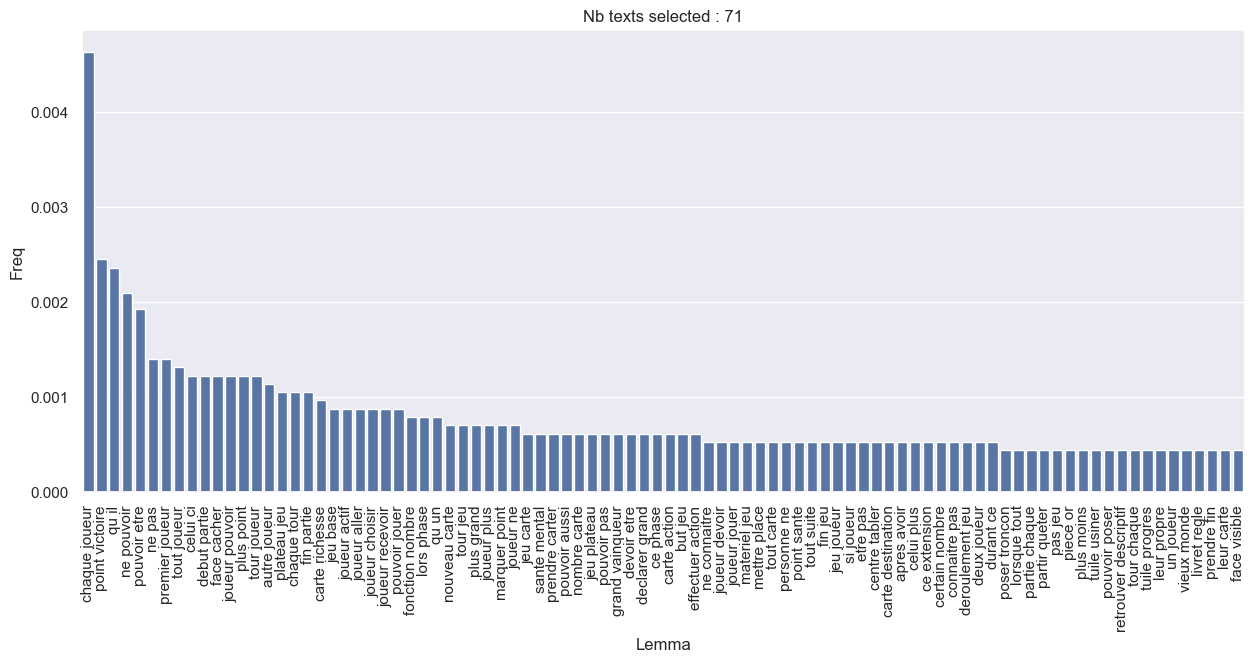

In [ ]:
desc_llm, bigrams = describe_cluster(2, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
bigrams.sort_values("Freq", ascending=False).iloc[0:50]
# #bigrams=["face cacher", "carte richesse", "carter politique", "livret regle", "paquet carte", "premier acheteur",
# #       "ordre tour", "objectif secret", "politique militaire", "faire commerce"]

# cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
# cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

# print("Nb words:", calc_nb_words(cluster_desc["Description"]))
# response=call_model_by_batch(cluster_desc_batched, "descriptions")
# print(response["message"]["content"])


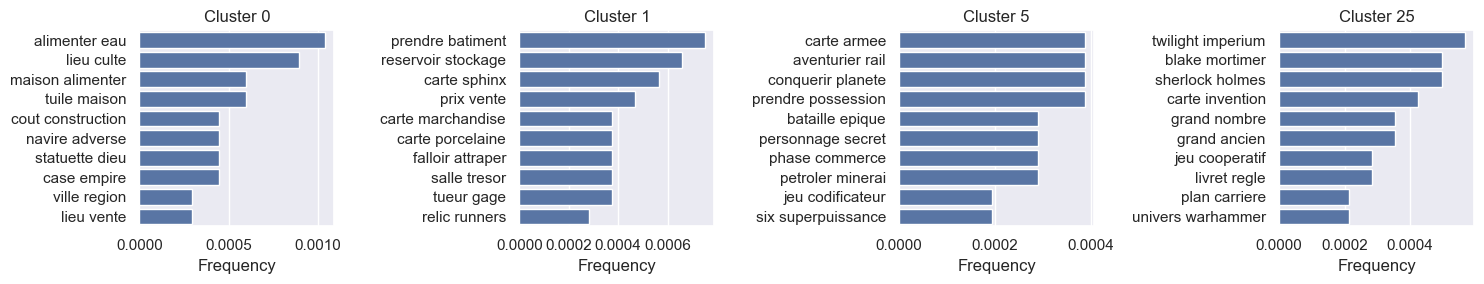

In [198]:
#df["Cluster"] = [5] * 10 + [0] * 10 + [1] * 10 + [25] * 10
df = df.sort_values("Freq", ascending=False)
df
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, cluster in enumerate(np.sort(df["Cluster"].unique())):
    bigrams = df[df["Cluster"] == cluster]
    sns.barplot(data=bigrams, x="Freq", y="Lemma", ax=axes[i])
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Frequency")
    axes[i].set_title(f"Cluster {cluster}")

plt.tight_layout()
fig.savefig("../images/bigrams.svg", format="svg", bbox_inches="tight")

### Cluster 3 

Capture territoire

Nb texts : 92 92
Description embeddings completed
Distance descriptions :  [0.59685524 0.61328528 0.62183207 0.63300627 0.63368706 0.63839058
 0.64160045 0.6444976  0.64573754 0.64925224]
CENTER DESC : But du jeu Chaque joueur incarne un chevalier qui essaie de faire passer sous son influence des
châteaux afin d’être le plus puissant du pays. Déroulement du jeu Par des jets de dés, il faut
réaliser des combinaisons de haute valeur (brelans, carrés, etc.). Ainsi, il sera possible de
contrôler des châteaux, de remporter des tournois et de gagner des cartes action. Les châteaux et
les tournois permettent de se rapprocher de la victoire. Les cartes action permettent de protéger
des châteaux, de changer les valeurs des dés, d’avoir des lancers supplémentaires… A chaque tour, on
essaie donc de gagner des cartes en lançant les dés. On peut aussi attaquer un adversaire pour lui
prendre une carte, mais celui-ci peut se défendre en essayant de réaliser une meilleure combinaison
aux dés. Fin du j

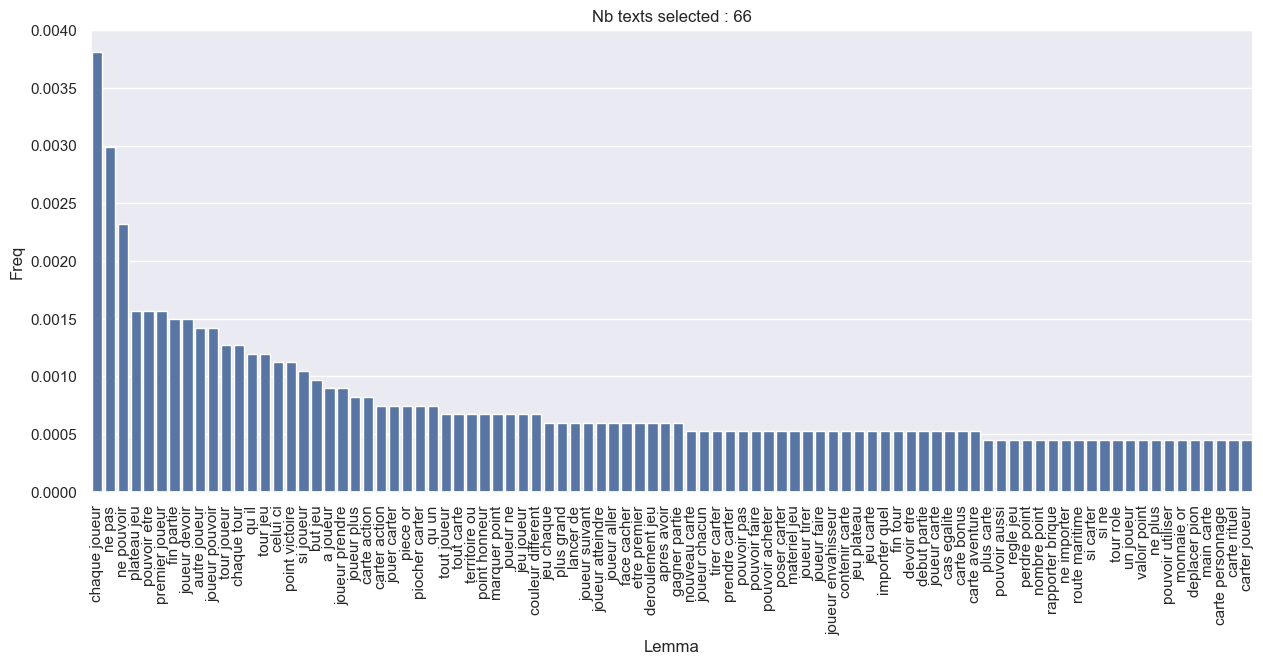

In [122]:
desc_llm, bigrams = describe_cluster(3, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
bigrams.sort_values("Freq", ascending=False).iloc[50:100]
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 4 --> logique, déduction


Superbes visuels

Nb texts : 74 74
Description embeddings completed
Distance descriptions :  [0.6253895  0.63047679 0.63607622 0.63918557 0.64677459 0.64908522
 0.65109681 0.65399376 0.6648494  0.66999879 0.67109142 0.67279669
 0.67363853 0.67387952 0.67430218]
CENTER DESC : Matériel : 56 cartes à jouer 7 familles de cartes de couleur 28 pions blasons (4 par joueur) 11
cartes en plus pour les variantes But : obtenir le maximum de points sur 3 manches, en faisant des
plis et à l'aide des blasons. Les points se comptent en fonction de la valeure des cartes et des
couleurs "blasons" face visible, possédés par le joueur. Préparation : chaque joueur prend une
couleur (8 cartes, identiques pour tous les joueurs), et les 4 blasons correspondants. Puis tous les
blasons sont mélangés face cachées, et chaque joueur en prend 3 devant soi, dont 1 qu'il retourne
face visible. Les blasons restants forment la pioche. Déroulement : Un par un, chaque joueur joue 1
carte.Une fois que tout le monde a joué, chacun applique

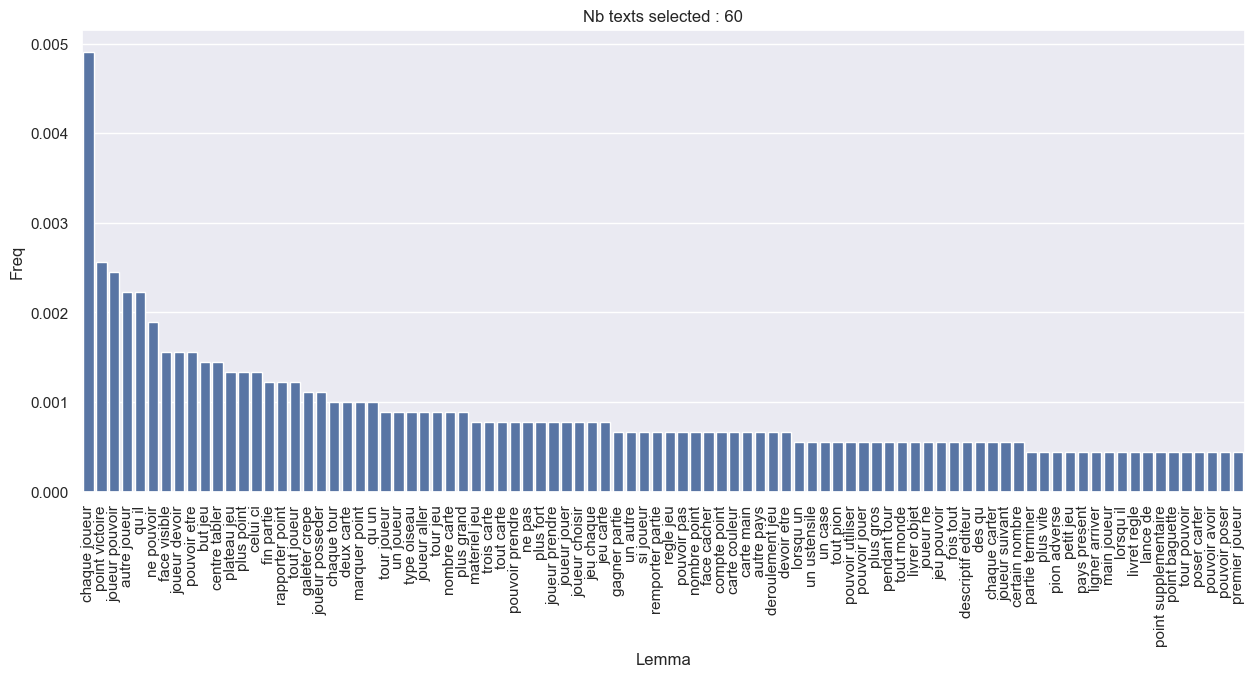

In [125]:
desc_llm, bigrams = describe_cluster(4, 1.25, 1.25, 15, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 6 

Culture | fantaisie

Nb texts : 59 59
Description embeddings completed
Distance descriptions :  [0.62502732 0.62961281 0.63128974 0.64025978 0.64066593 0.65475556
 0.65502433 0.65614903 0.66159378 0.67026083]
CENTER DESC : Chaque joueur, à son tour, va poser une carte sur la table, construisant peu à peu une aire de jeu.
Quand un joueur pose une carte identique à une autre déjà placée et qui se trouve sur une même ligne
ou une même colonne; il capture les cartes situées entre chaque. Il arrive donc que des "lots" de
cartes soient ainsi coupés les uns des autres. Quand ceci arrive (suite à une capture), les joueurs
ne pourront plus tenter de nouvelles captures tant que toutes les cartes du jeu ne sont pas à
nouveau connectées. Sur chaque carte Dweebies, se trouve indiqué sa fréquence en jeu. La partie se
termine quand les joueurs ne peuvent plus placer de nouvelles cartes. Le joueur ayant capturé le
plus de cartes remporte la partie. Matériel : - 54 cartes (comprenant 27 Dweebies différents) - 1
règles de j

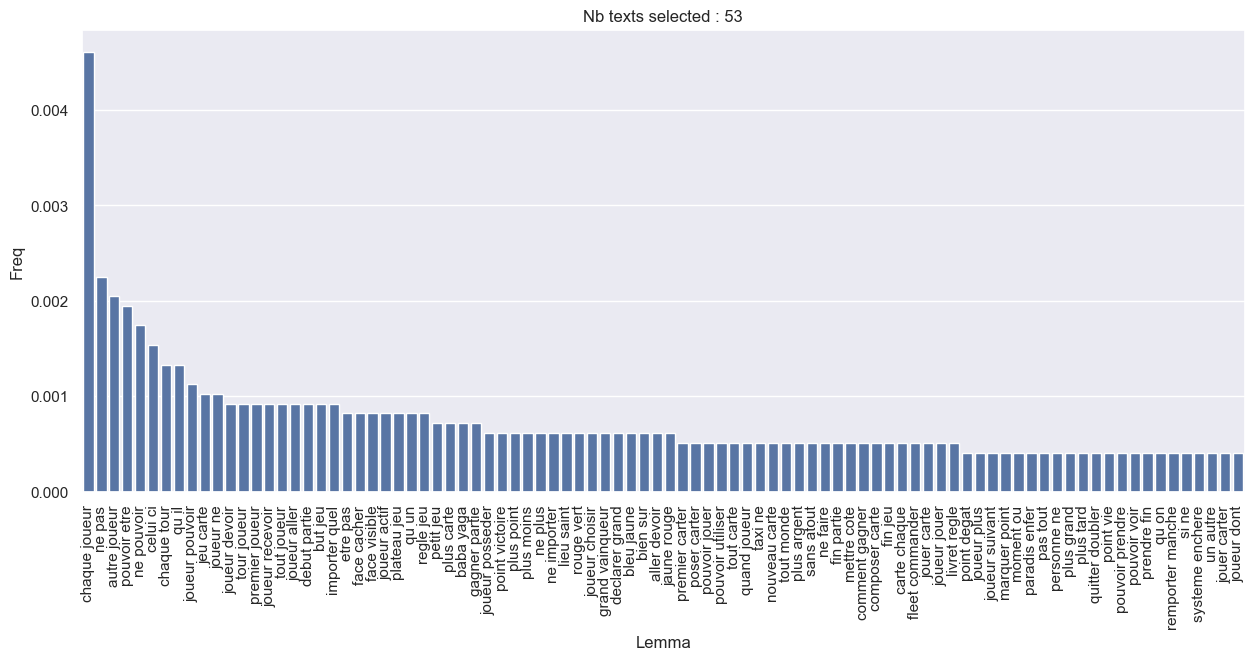

In [210]:
desc_llm, bigrams = describe_cluster(6, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 7 

Culture | Fantaisie


Nb texts : 94 94
Description embeddings completed
Distance descriptions :  [0.61954451 0.63135013 0.63772734 0.64441024 0.65481849 0.65833395
 0.65846117 0.66135245 0.67104586 0.6804978  0.68119112 0.68291029
 0.68391924 0.68412769 0.6855009 ]
CENTER DESC : Chaque joueur fait partie de l'équipe des Héros ou des Zombies. Les héros sont 4 au total, et pour
gagner doivent remplir les conditions d'un scénario (par exemple tuer 15 zombis). Les zombies
doivent l'en empêcher, ou tuer un certain nombre de héros. Chaque équipe joue à son tour, tire des
cartes événements qui vont l'aider ou pénaliser l'autre. Les héros peuvent se rendre dans des
bâtiments ou ils peuvent tirer de nouvelles cartes ou aller chercher d'anciennes cartes. Les
déplacements se font à l'aide d'un dé pour les héros, tandis que les zombis n'avancent que d'une
case mais ne sont pas bloqués par les murs. Les déplacements ont lieu sur un plateau modulaire, et
la partie est gérée par des scénarii fondés sur les grands classiqu

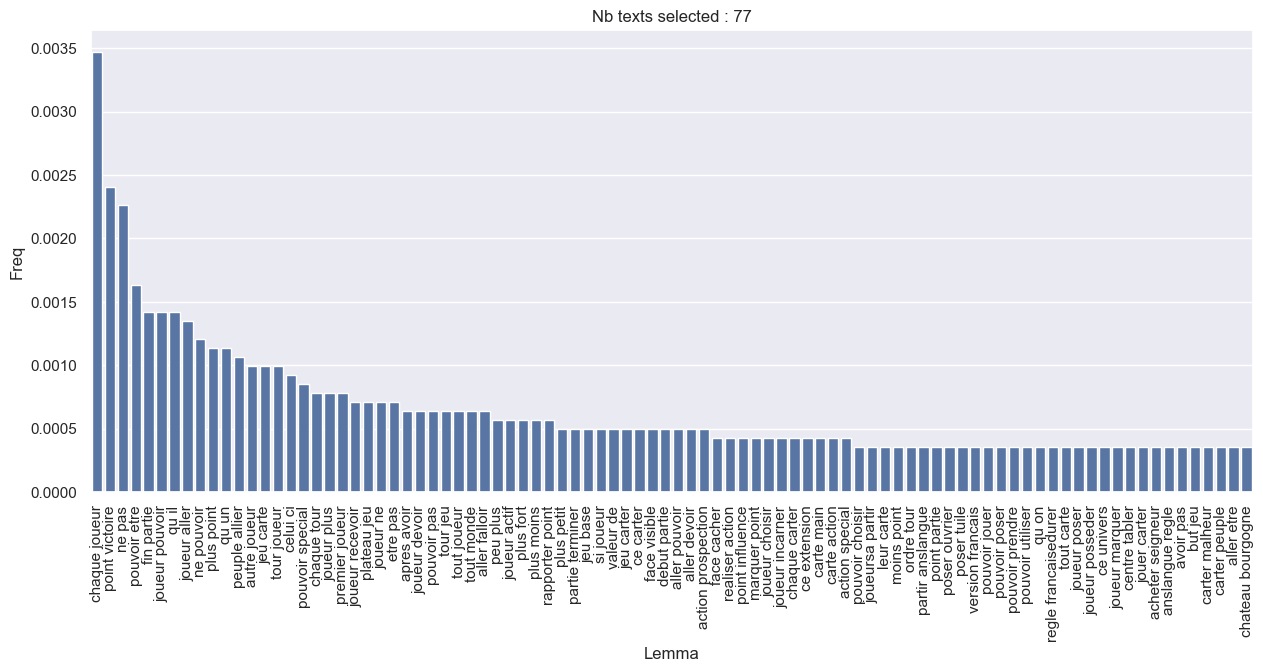

In [211]:
desc_llm, bigrams = describe_cluster(7, 1.25, 1.25, 15, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])

cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 8

Superbes visuels

Nb texts : 109 109
Description embeddings completed
Distance descriptions :  [0.60399487 0.64256758 0.64526683 0.64805991 0.64939674 0.65635973
 0.65713514 0.65852806 0.66387574 0.66513986]
CENTER DESC : But du jeu Les joueurs se glissent dans la peau de chasseurs de trésors et essayent, durant la
partie, de récolter de précieux trésors et de céder des trésors maudits aux autres joueurs. A la fin
du jeu, le joueur qui possède les trésors les plus précieux est le vainqueur. Déroulement du jeu
Chaque joueur reçoit une carte camp et trois cartes trésors sont placées face visible au milieu de
la table. À son tour, un joueur joue une carte aventure face visible dans la rangée aventure sous
une carte trésor. Il complète ensuite sa main. La carte aventure jouée compte toujours en faveur du
joueur qui possède la carte camp de la même couleur. A son tour, un joueur ne peut jouer qu’une
carte action (échanger des cartes, rejouer, jouer face cachée...). Cette carte action doit être
jouée avant la

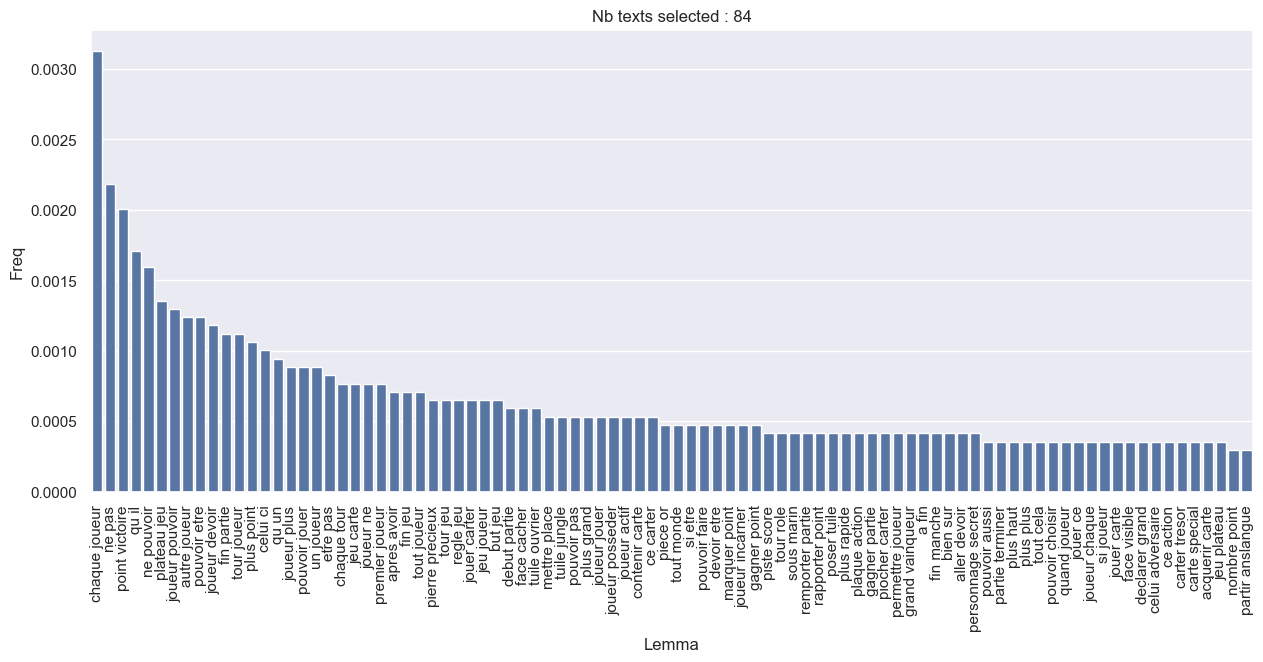

In [128]:
desc_llm, bigrams = describe_cluster(8, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 9

Longs & complexes

Nb texts : 71 71
Description embeddings completed
Distance descriptions :  [0.61765848 0.63219224 0.63345266 0.63381608 0.64369605 0.64447477
 0.64624914 0.64937541 0.65480694 0.66003969]
CENTER DESC : Dans cette adaptation du jeu télévisé, chaque joueur incarne le maître de jeu tour à tour. Les
autres joueurs jouent simultanément en tentant tous de répondre aux mêmes questions, de plus en plus
difficiles, pour remporter un gain (fictif, bien entendu...) de plus en plus élevé ! Pour chaque
question, 4 réponses sont proposées. Pour les aider dans leurs réponses, les joueurs ont droit à 3
jokers : le 50:50, qui permet de retirer 2 fausses réponses ; le Vote du Public, qui permet de
connaître l'avis des autres joueurs ; et enfin l'Appel à un ami, qui l'autorise à demander l'avis
d'un des autres joueurs (ou pourquoi pas d'appeler réellement une autre personne!) Une série de
questions s'achèvent lorsque tous les joueurs ont abandonné ou mal répondu (ou atteint le gain le
plus élevé !). Chac

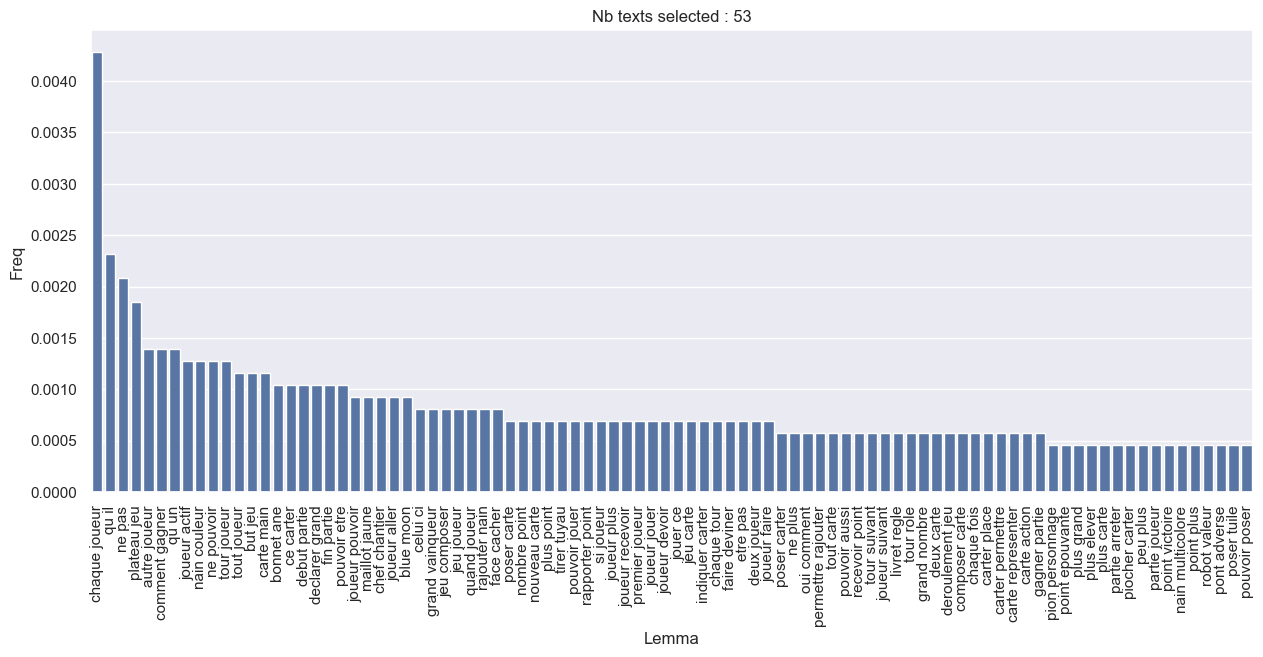

In [129]:
desc_llm, bigrams = describe_cluster(9, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 10 -> worst rated

Nb texts : 73 73
Description embeddings completed
Distance descriptions :  [0.18192966 0.20382893 0.22124665 0.22783937 0.23359083 0.23542874
 0.23597912 0.24570889 0.24738036 0.24889604]
CENTER DESC : Le but du jeu est de se défausser d'un maximum de cartes. On reçoit un paquet de cartes face cachées
au début. A son tour, le joueur retourne une carte de son paquet. Selon le dessin, tous les joueurs
doivent réagir ou non. Par exemple, si la carte retournée représente un lapin chef d'orchestre, il
faut se lever puis se rasseoir. Si un joueur à la mauvaise réaction ou pas de réaction alors qu'il
fallait faire quelque chose il ramasse toutes les cartes. Si plusieurs joueurs sont dans cette
situation, ils partagent le paquet. Puis on passe au joueur suivant. Quand un 1er joueur n'a plus de
carte, il a le droit d'induire les autres en erreur, de faire le mauvais geste ou de réagir alors
qu'il ne fallait pas. Quand un deuxième joueur a terminé son paquet, celui qui a le plus de cartes
dans s

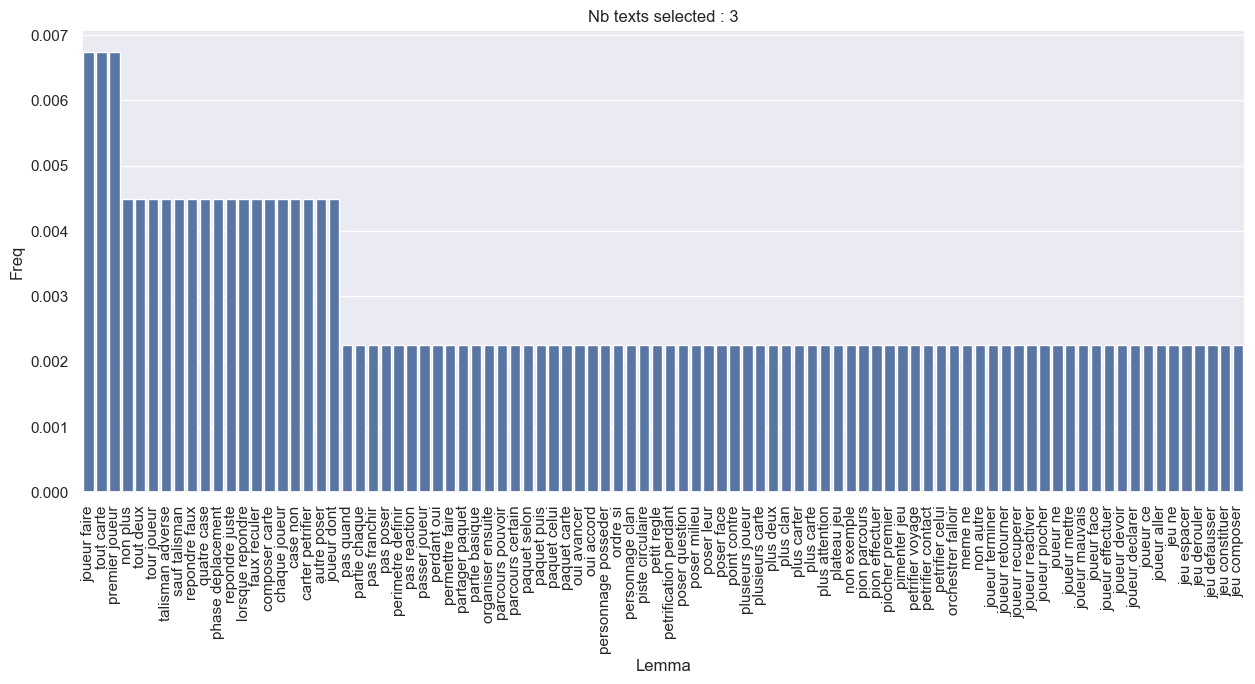

In [ ]:
# desc_llm = describe_cluster(10, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_real, comment_lemmatized, comment_real, comments=False)
# #print("Games selected", cluster_desc.shape[0])
# cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
# cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

# print("Nb words:", calc_nb_words(cluster_desc["Description"]))
# response=call_model_by_batch(cluster_desc_batched, "descriptions")
# print(response["message"]["content"])

### Cluster 11 

Capture territoire

Nb texts : 93 93
Description embeddings completed
Distance descriptions :  [0.5952057  0.59967666 0.60825693 0.61118563 0.63004635 0.63061936
 0.63249536 0.6327447  0.63441939 0.63560139]
CENTER DESC : But du jeu : Obtenir le maximum de "+" à la fin de la partie. Le jeu se déroule en une succession de
manches, composées de tours. À chaque tour, un joueur devient donneur. Il prend autant de cartes que
de joueurs et va les répartir successivement en retournant les cartes les unes après les autres.
Chaque joueur recevra donc une carte. Le donneur en choisira une pour lui parmi les cartes prises.
Effet des cartes : -les cartes "+" sont immédiatement ajoutées aux cartes gagnées. -les cartes avec
des chiffres sont conservées face visibles. (certaines ont des "+") -D'autres cartes ont des effets
spéciaux : tirage d'une nouvelle carte, veto (refuser une carte ultérieurement), défausse (la
dernière reçue, obligatoirement !) ou encore 13->18 qui augmente le "plafond". La manche s'arrête
dès qu'u

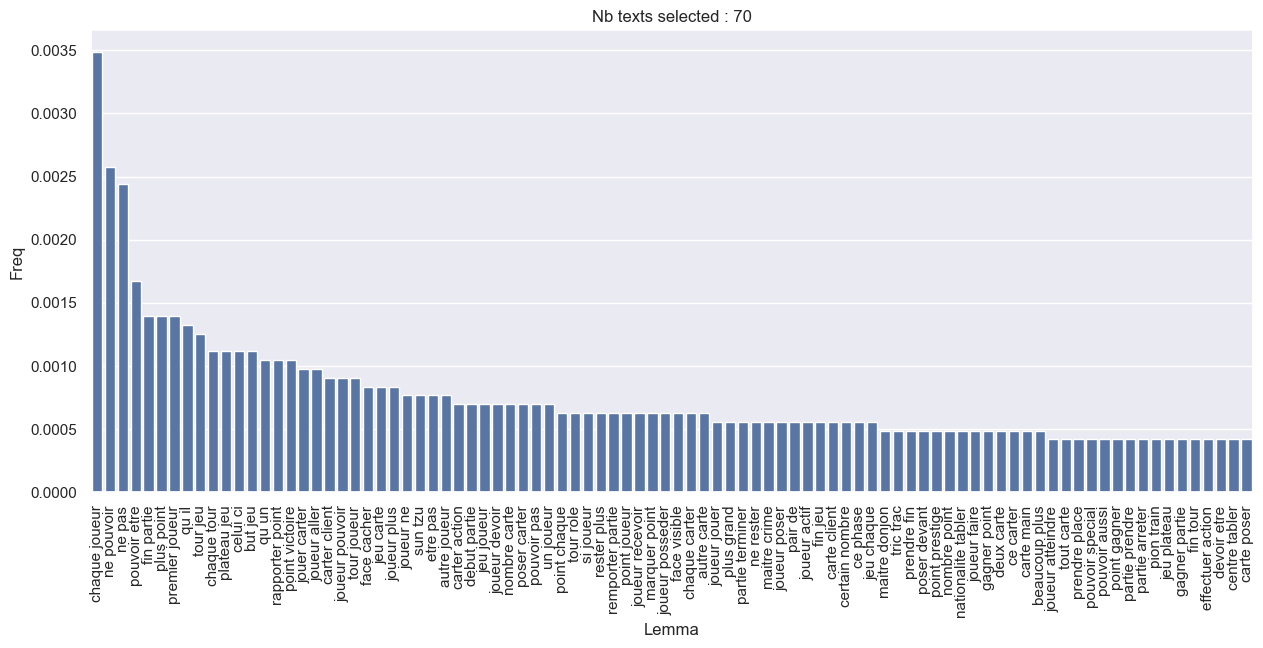

In [130]:
desc_llm, bigrams = describe_cluster(11, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 12

De type Civilisation

Nb texts : 69 69
Description embeddings completed
Distance descriptions :  [0.64023237 0.64148353 0.64396879 0.65050491 0.65399989 0.66506565
 0.66692161 0.66866365 0.67065966 0.67923572]
CENTER DESC : Le roi demeure dans un pays lointain. Pendant ce temps son royaume tombe dans l'anarchie et le chaos
et les princes en présence vont se battre pour étendre leurs domaines... Au départ, chaque joueur va
placer ses différents châteaux à une distance minimum de 6 cases sur le plateau de jeu, accompagné
d'un chevalier. Chaque joueur va alors essayer de former des domaines autour de ses châteaux. À son
tour, un joueur va recolter les revenus de ses mines puis effectuer au choix une des 2 actions
suivantes: - Vendre une de ses cartes pouvoir au marché pour un prix fixé. - Jouer une de ses cartes
pouvoir en payant un coût lui aussi fixé. Les effets des cartes pouvoir sont de 5 types: -Blason
vert: Poser de 1 à 3 frontières (permettant de délimiter son domaine mais également celui des
voisins) -

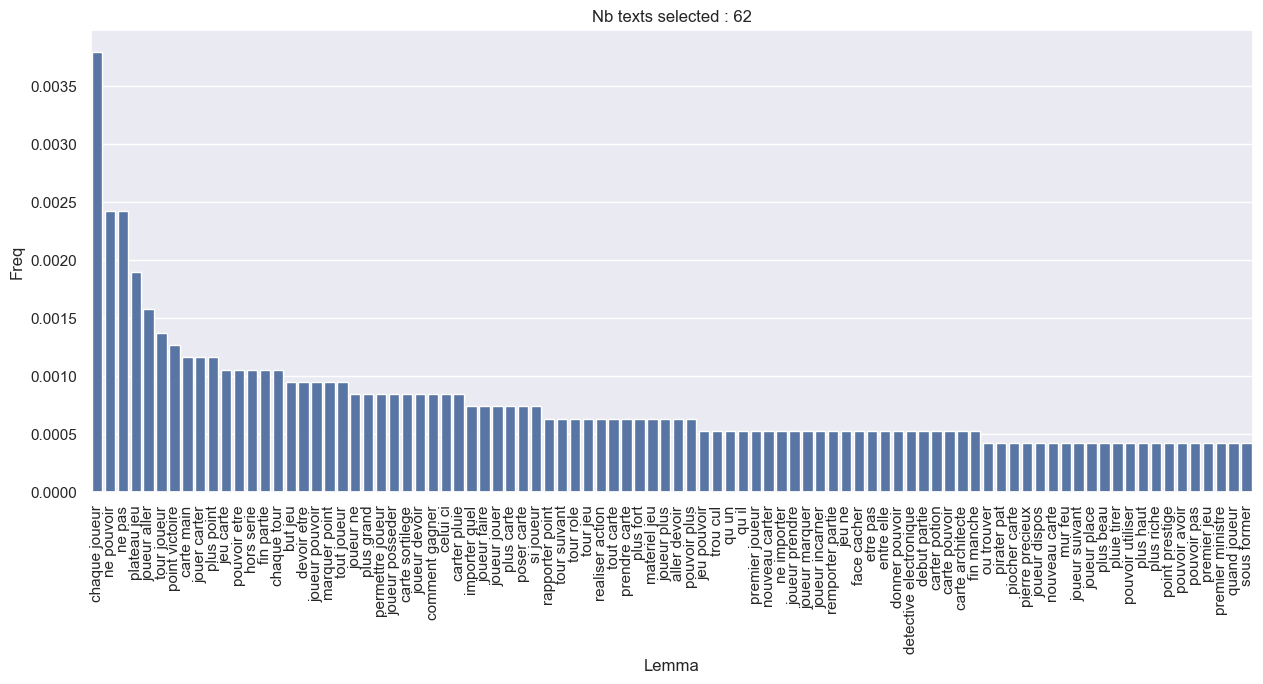

In [226]:
desc_llm, bigrams = describe_cluster(12, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)

cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 13

Longs & complexes

Nb texts : 83 83
Description embeddings completed
Distance descriptions :  [0.62858024 0.64196655 0.64683706 0.6575456  0.65999591 0.66189736
 0.66423874 0.66428093 0.66614944 0.67146943]
CENTER DESC : Le joueur posséde un jeu de cartes de sa couleur dont il doit se débarasser le plus rapidement
possible. Sur une carte, 6 ronds de couleurs différentes. On peut assembler 2 cartes si on peut
superposer 2 ronds de couleurs (cachés alors par la nouvelle carte et permettant alors de nouvelles
combinaisons). Les cartes peuvent être gardés en main ou posés sur la table (pour une meilleure
visibilité). Tout se fait bien sûr en simultané! La partie se termine quand un joueur pose toutes
ses cartes. Le joueur avec le plus de points gagne sachant que: - chaque carte posée rapporte 1
point - les cartes restant en main valent 1 point de malus - les erreurs coutent chacune 2 points de
malus. 

Nb words: 3617
2
Nb tokens: 5723
Je vais vous présenter un résumé des descriptions fournies et identifier l

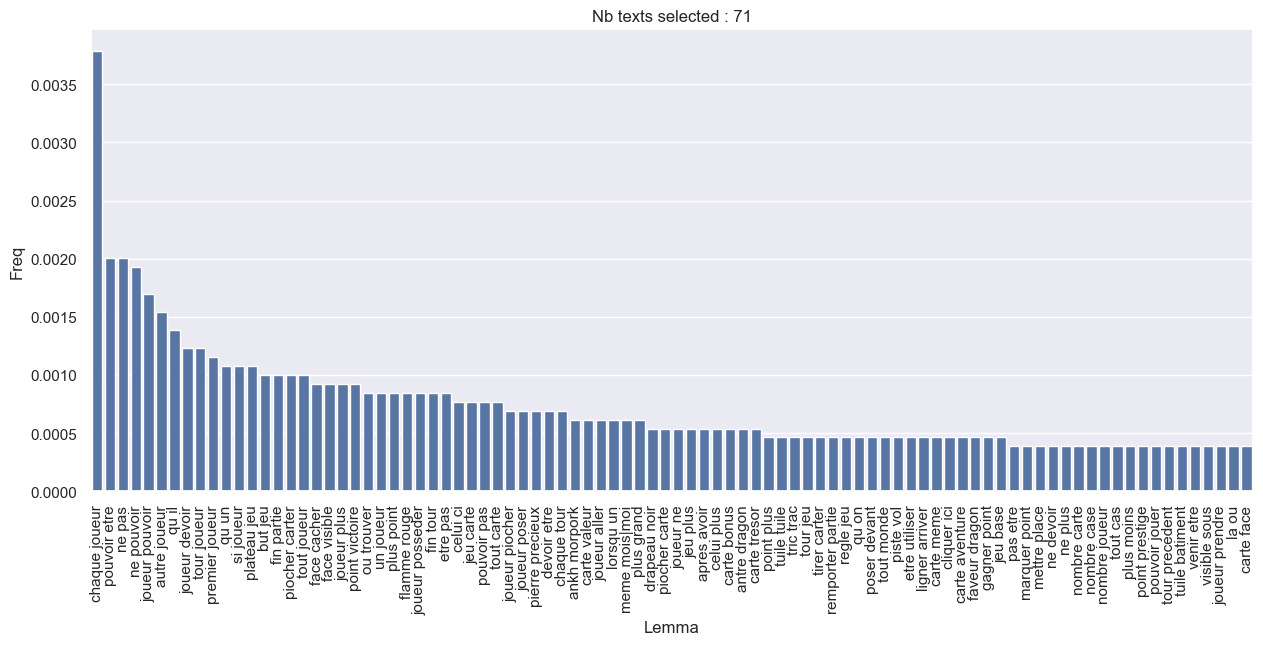

In [133]:
desc_llm, bigrams = describe_cluster(13, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 14

Rapide & tactique

Nb texts : 95 95
Description embeddings completed
Distance descriptions :  [0.61325942 0.62118499 0.62861274 0.63744518 0.63752256 0.63787143
 0.6387707  0.63934944 0.64057511 0.64603632]
CENTER DESC : Chacun leur tour, les joueurs piochent 5 cartes et les jouent. Ils améliorent leur deck
progressivement en achetant des cartes Action et Champion issus d'une ligne centrale (le marché).
Les cartes offrent des bonus d'or (pour les achats) ou de points de combat qui permettent d'attaquer
l'adversaire et d'assomer ses Champions. Le premier joueur à mettre l'autre à 0 gagne la partie.
L'utilisation des Decks de Héros est recommandée et permet de varier les parties en changeant les
decks de départ des joueurs. Il existe également 5 Booster pour les Deck de Héros, ils sont à 4€
chacun. 

Nb words: 3056
2
Nb tokens: 4790
Voici une analyse synthétique des descriptions de jeux présentées :

**Mécaniques clés**

* Chacun leur tour, les joueurs piochent et jouent cartes Action et Champion pour amél

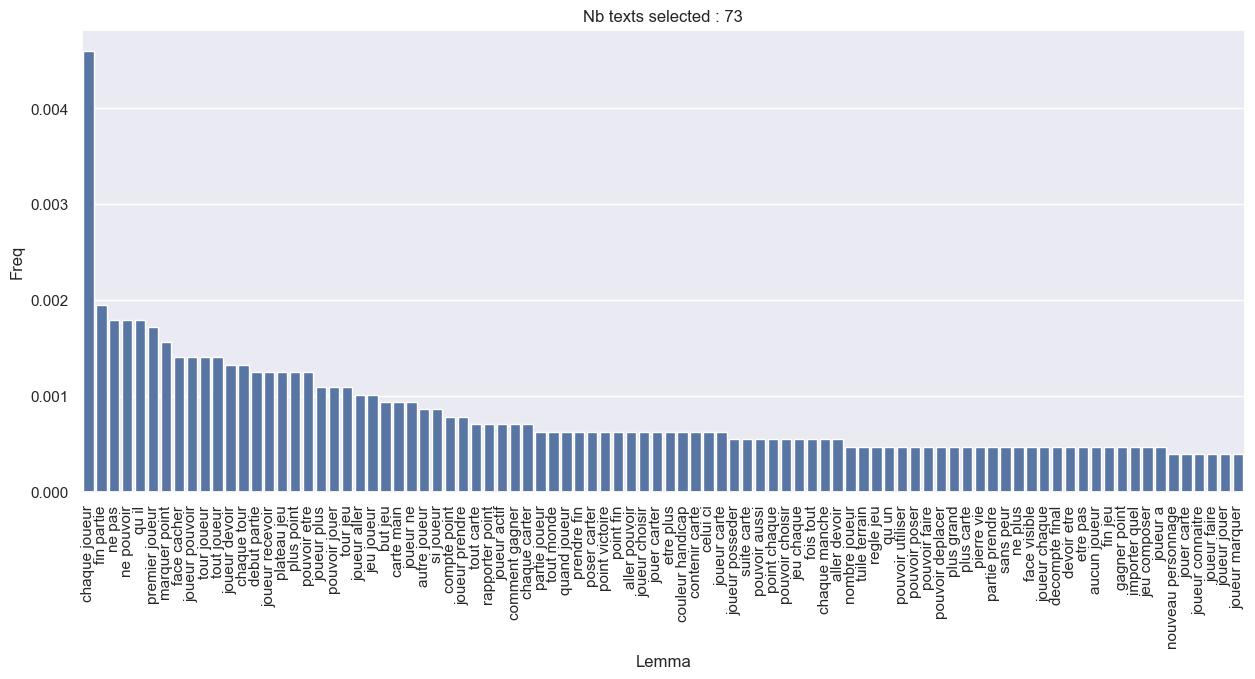

In [225]:
desc_llm, bigrams = describe_cluster(14, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 15

Eurogames

Nb texts : 99 99
Description embeddings completed
Distance descriptions :  [0.22891081 0.2377024  0.23795484 0.23893495 0.24721321 0.25133022
 0.25224008 0.25281517 0.25546634 0.25624473]
CENTER DESC : Contenu de la boîte : - Un plateau de jeu représentant un circuit (type je de loie) en forme de
terrain de foot. - un dé, - 4 pions joueur, - 4 plaquettes Calcul des scores, - des billets de
banque, - des cartes joueurs Nationaux, Étrangers et Internationaux, - des cartes Euromatch, - des
cartes Chance, - des cartes Action. Une partie de déroule en deux phases. Dans la première phase,
les joueurs démarrent sans carte mais avec une somme d'argent. Les joueurs circulent librement sur
le circuit en forme de terrain de foot. Des cases leur permettent de piocher des cartes Chance,
Action, d'acheter des cartes Joueur avec leur argent, ou d'autres événement tels que payer une somme
d'argent, en recevoir, rejouer... Les cartes Joueur que vous acheter ont un prix d'achat et un prix
de revente (pl

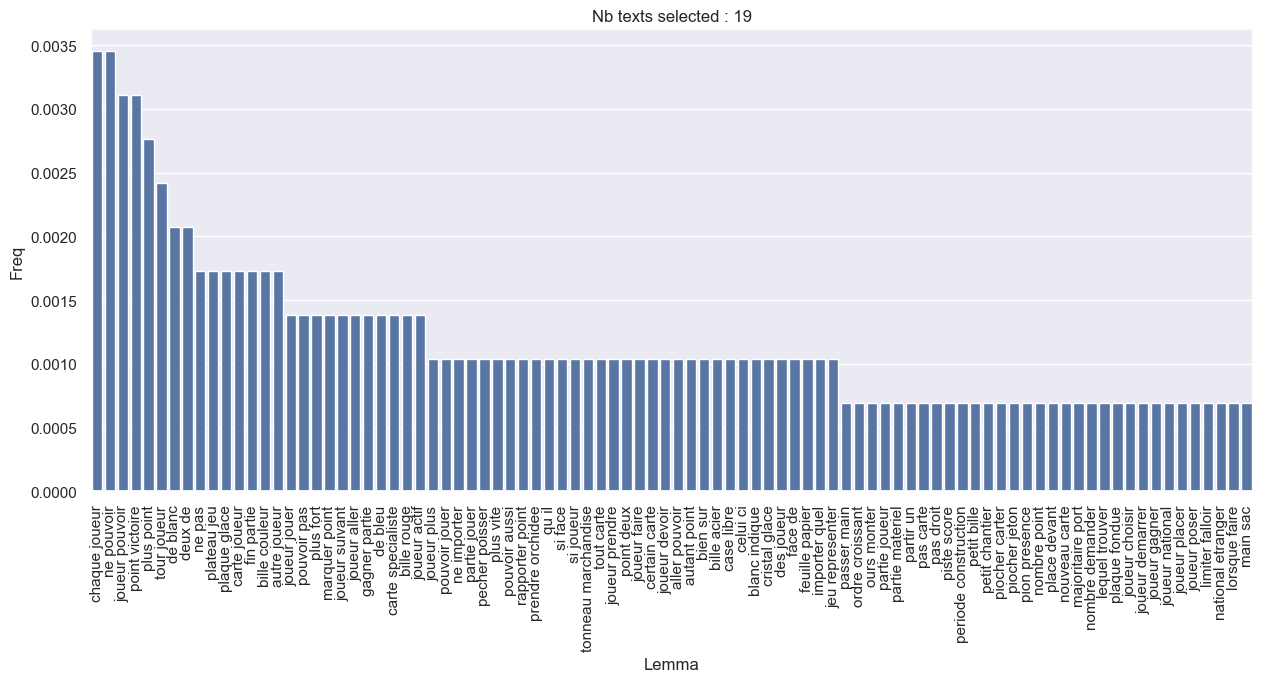

In [ ]:
desc_llm, bigrams = describe_cluster(15, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 16

Eurogames

Nb texts : 100 100
Description embeddings completed
Distance descriptions :  [0.22033576 0.22171552 0.22349395 0.22497458 0.22648087 0.22855031
 0.2298809  0.23090361 0.23132712 0.23578591]
CENTER DESC : Chaque joueur dirige une tribu de cinq personnes. À chaque tour, il va falloir les envoyer
travailler pour ramener un maximum de points de victoire. Comment on joue. À chaque tour, on prend
un ou plusieurs personnages et on les assigne à une tâche. Ils peuvent aller chercher des ressources
: de la nourriture en bons chasseurs-cueilleurs qu'ils sont, du bois, des briques, de la pierre ou
de l'or. Sauf pour la nourriture, illimitée, il n'est pas possible, pour tous les joueurs, d'envoyer
plus de sept personnes pour chaque ressource. Pour chaque personnage présent, on va lancer un dé
pour savoir combien de ressources les ils vont ramener. On obtient un point de nourriture par
tranche de 2 aux dés, 3 pour le bois, 4 pour la brique, 5 pour la pierre et 6 pour l'or. (Exemple :
J'ai 3 ouvrier

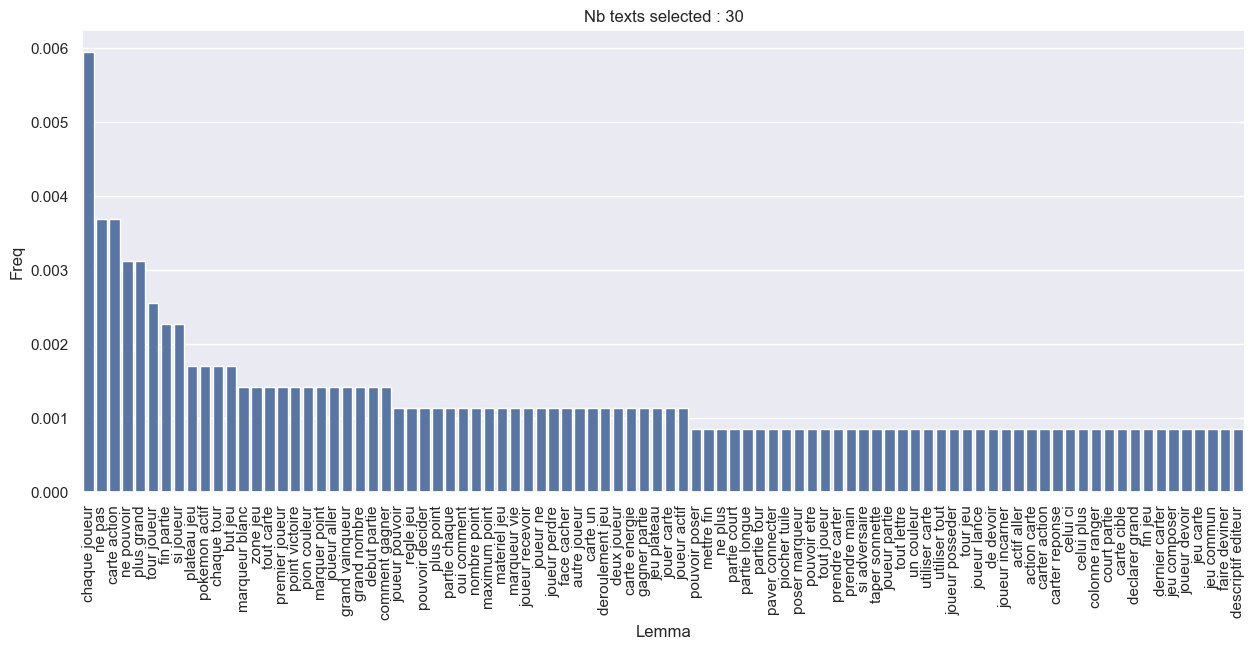

In [ ]:
desc_llm, bigrams = describe_cluster(16, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 17

Collecte

Nb texts : 81 81
Description embeddings completed
Distance descriptions :  [0.21520382 0.2302172  0.2304623  0.23707938 0.23766246 0.24755529
 0.2493768  0.251449   0.25214159 0.25249806]
CENTER DESC : Chaque joueur dirige un peuple de créatures appétissantes. Le plateau de jeu représente la table
à manger d’un géant affamé. Les joueurs vont essayer d’y propulser les créatures de leurs
adversaires afin qu’elles soient mangées. La boîte de jeu contient 57 cartes « famille », 66
cartes «action », 1 plateau de jeu, 1 règle du jeu, 1 livret de règles. 

Nb words: 2232
2
Nb tokens: 3568
Je vais essayer de résumer les descriptions en français et identifier les mécaniques clés et le public cible pour chaque jeu.

1. **La nouvelle extension du petit bac** :
 * Mécanique : Les joueurs doivent choisir des thèmes et collecter des cartes avec des lettres correspondant à l'initiale du thème choisi.
 * Public cible : Enfants et adolescents, car le jeu est conçu pour être simple et amusant

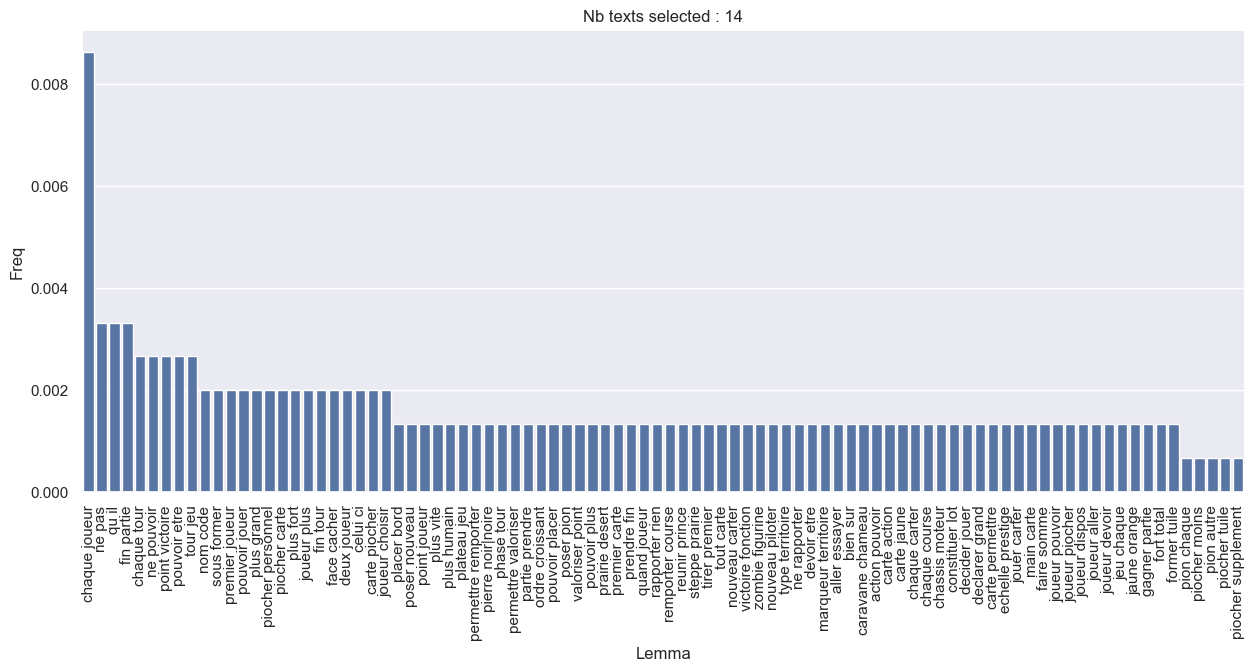

In [ ]:
desc_llm, bigrams = describe_cluster(17, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 18

De type Civilisation

Nb texts : 92 92
Description embeddings completed
Distance descriptions :  [0.61141343 0.63175259 0.63683451 0.64670414 0.65727149 0.66050157
 0.66772125 0.6704486  0.67237123 0.6785905 ]
CENTER DESC : Au tour de chaque joueur, neuf cartes représentant des cadeaux sont placées sur le plateau de jeu
commun. Chacun doit alors choisir lequel de ces cadeaux il ferait à chacun des autres joueurs, puis
les trois cadeaux qui lui feraient le plus plaisir de recevoir, ainsi que celui qu’il n’aimerait
vraiment pas qu’on lui fasse. Les choix des joueurs sont ensuite révélés. Chaque cadeau apprécié par
son destinataire fait marquer des points aux deux joueurs, celui qui l’offre et celui qui le reçoit.
Un cadeau dont on ne voulait vraiment pas fait à l’inverse perdre des points aux deux joueurs. Ce
jeu est en anglais mais les textes sont simples et illustrés(une phrase en général) et sont les
mêmes pour tous les joueurs. Il suffit donc d'une traduction collective (les images aident
beaucoup). 

Nb 

,Lemma,Freq
64,plus moins,0.000419
68,tout joueur,0.000419
66,qu on,0.000419
67,quel couleur,0.000419
69,trouver quel,0.000419
70,un joueur,0.000419
59,joueur poser,0.000419
60,livret regle,0.000419
47,aller permettre,0.000419
58,jeu derouler,0.000419


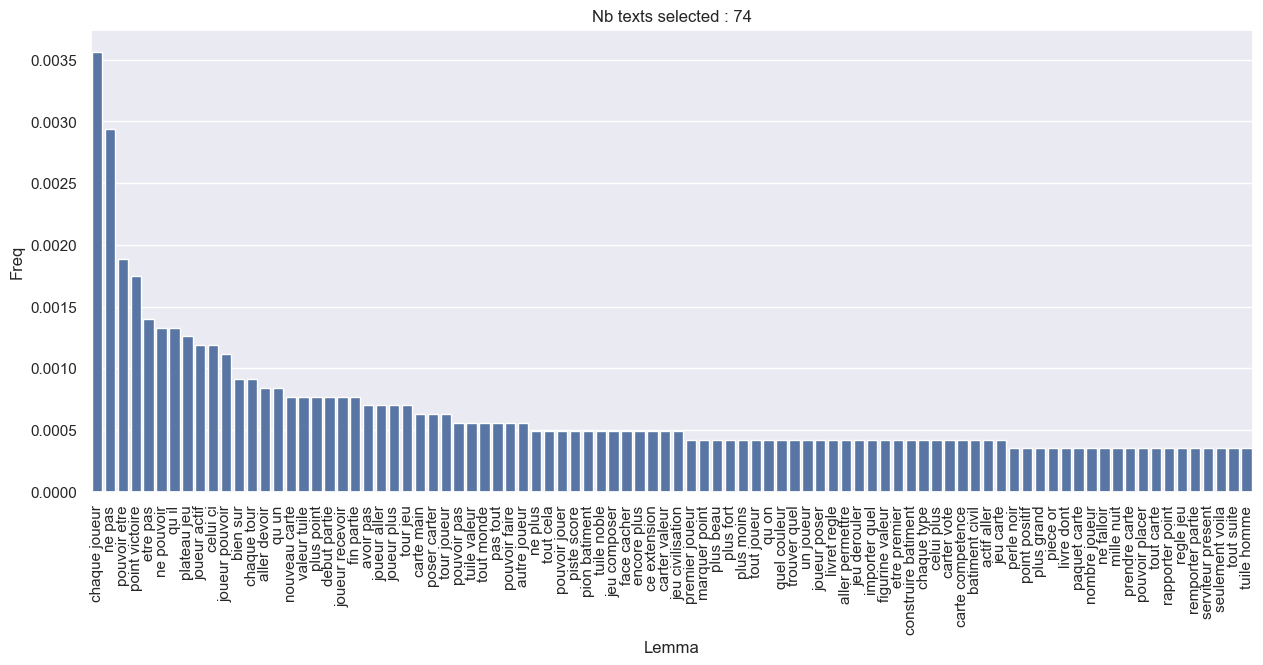

In [221]:
desc_llm, bigrams = describe_cluster(18, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])

cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])
bigrams.sort_values(by="Freq", ascending=False).iloc[50:100]


### Cluster 19 

Construction & expension

Nb texts : 68 68
Description embeddings completed
Distance descriptions :  [0.22225178 0.24399307 0.24531156 0.2518675  0.25396631 0.25411636
 0.25592505 0.25845181 0.26054058 0.26336354]
CENTER DESC : Chaque joueur mélange les 18 cartes de valeur 1 à 9 de sa couleur. À son tour de jeu, il en pioche
une au hasard et la pose à côté d'une carte déjà sur la table, ou en recouvre une de valeur
inférieure. Le premier à aligner 4 de ses cartes (5 à 2 joueurs remporte la manche. Deux manches
gagnées et la victoire est à vous. 

Nb words: 3041
2
Nb tokens: 5046
Voici une analyse des descriptions de jeux donnés :

**Thèmes communs**

* La plupart des jeux présentent des thèmes de stratégie et de planification, avec un accent sur la gestion des ressources et les décisions éclairées.
* Certains jeux présentent des éléments de compétition et de rivalité, tels que les combats ou les concours.

**Mechaniques de jeu**

* Les mécaniques de jeu les plus présentes sont :
 + La construction et la gestion

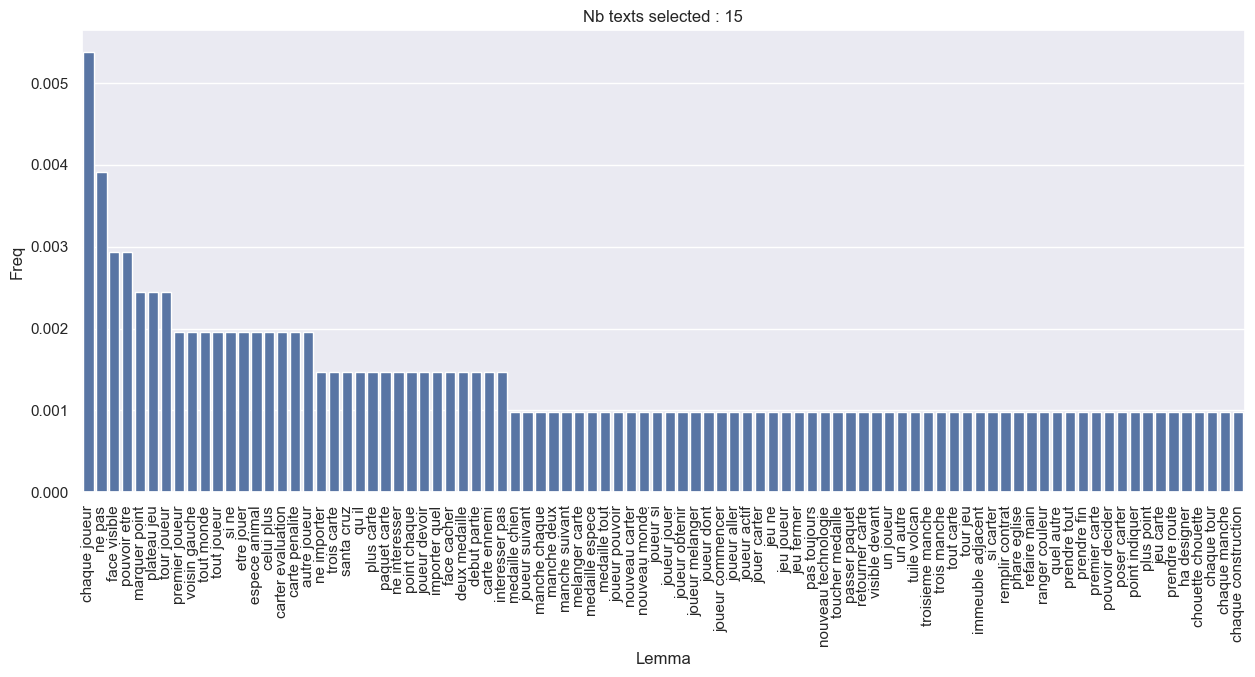

In [ ]:
desc_llm, bigrams = describe_cluster(19, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 20

Rapide & tactique

Nb texts : 66 66
Description embeddings completed
Distance descriptions :  [0.2053368  0.21539008 0.23490487 0.23772953 0.24581671 0.24856296
 0.25246863 0.25646188 0.25910238 0.26064357]
CENTER DESC : Matériel : -un plateau de jeu, -un plateau de score, -5 pions chef de tribu, -188 boucliers (46
rouges, 46 bleus, 32 noirs, 32 verts, 32 oranges) -12 marqueurs de pays, -un marqueur d'action, -98
cartes, -deux résumés des règles. Europe, an 412. Cinq tribus vont se développer et conquérir de
nouvelles terres : les Huns, les Lombards, les Goths, les Vandales et les Anglo-saxons. Le plateau
représente l'Europe, sur une carte divisée en cases, repérées par des lettres (de A à J) et des
chifres (de 1 à 10).Le continent est divisé en 12 pays. Il y a des cases de mer, et une piste de
score entoure la carte. Chaque joueur préside à la destinée d'une tribu, et va tenter d'imposer sa
domination sur le continent. À chaque tour, les joueurs reçoivent 10 cartes. En jouant ses cartes,
le joueur va po

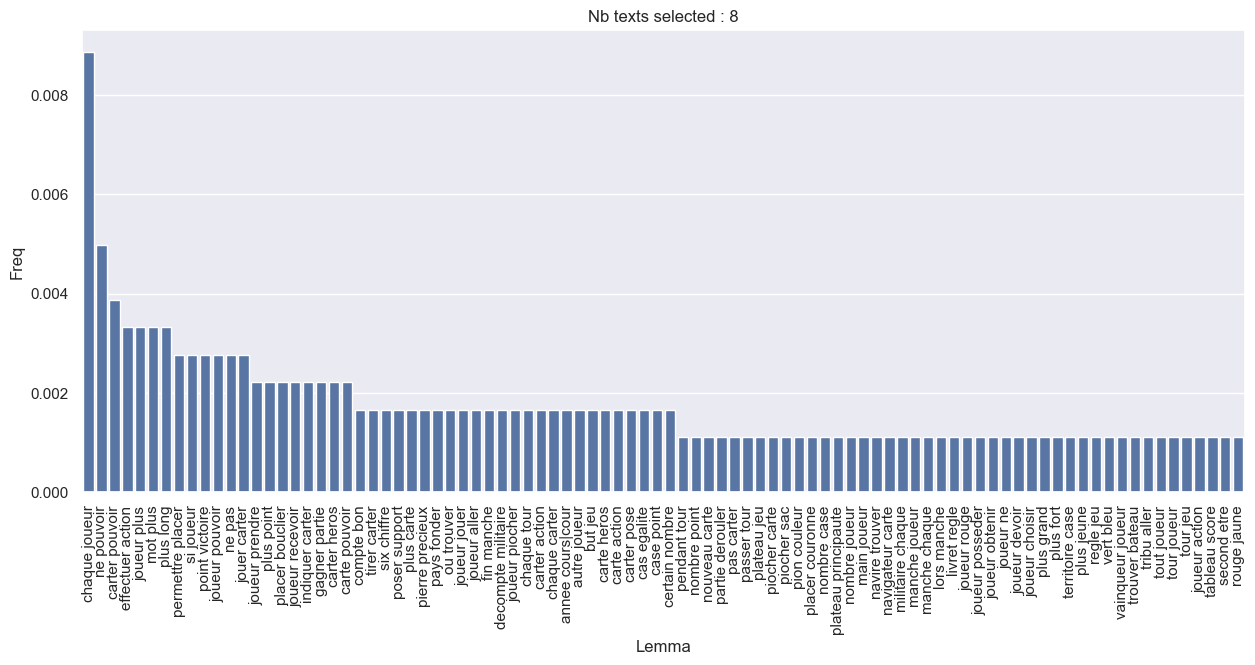

In [ ]:
desc_llm, bigrams = describe_cluster(20, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 21 

De type Civilisation

Nb texts : 90 90
Description embeddings completed
Distance descriptions :  [0.2071919  0.22425302 0.23186143 0.24098775 0.24995078 0.25261609
 0.25300966 0.25409635 0.25975729 0.26016242]
CENTER DESC : Le jeu est constitué d'un plateau sur lequel sont posés aléatoirement en début de chaque manche 6
cubes de couleurs différentes (rouge, orange, jaune, vert, bleu, violet) qui forment un spectre de
couleurs, ainsi que 20 pions colorés à raison de 10 par joueur. Ces pions sont également piochés et
répartis au hasard et sont au nombre de 30, 5 dans chacune des 6 couleurs (il y a donc toujours 10
pions d'écartés). Le but pour chacun des joueurs est de réorganiser sa ligne de pions en fonction de
l'ordre des couleurs du spectre de couleurs. Les deux joueurs disposent de 5 cartes Action en début
de chaque manche et, à tour de rôle, vont devoir en jouer une puis compléter leur main. Ces cartes
Action ont divers effets : . intervertir les 2 extrémités de sa ligne de pions ; . intervertir 2
pions

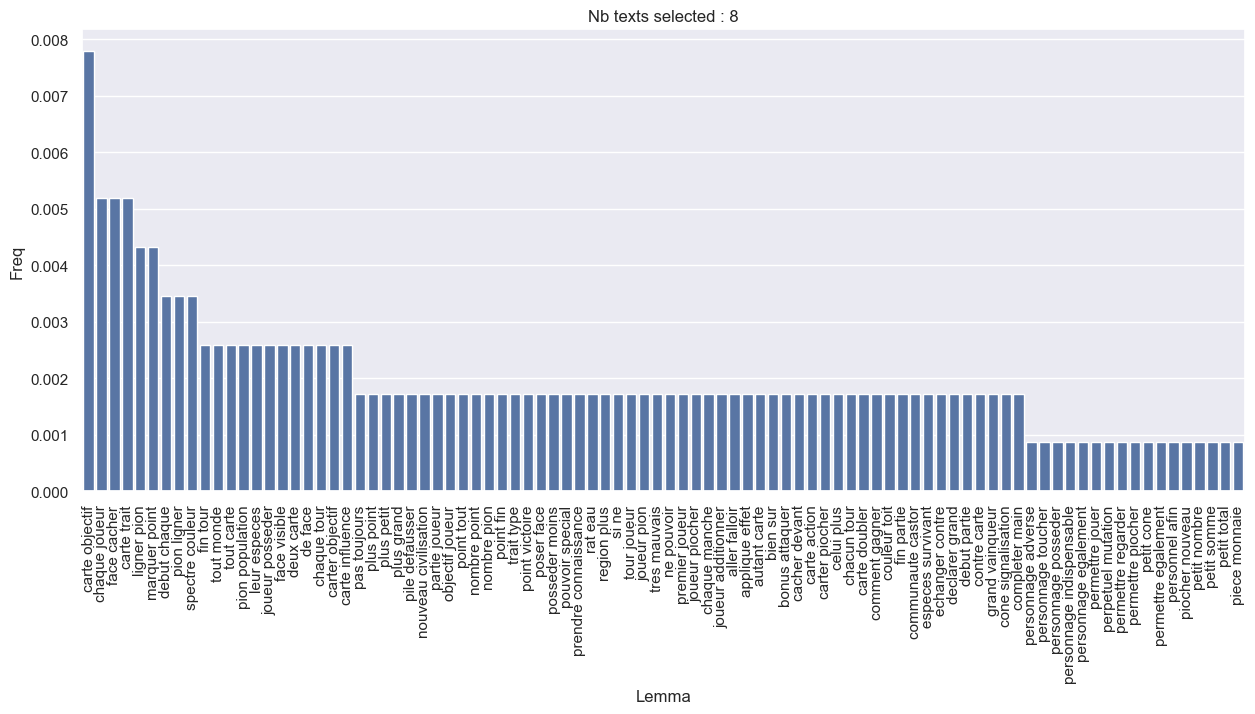

In [ ]:
desc_llm, bigrams = describe_cluster(21, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 22

Logique & déduction


Nb texts : 75 75
Description embeddings completed
Distance descriptions :  [0.18487697 0.18548263 0.20803619 0.21520235 0.23770166 0.23845838
 0.23937035]
CENTER DESC : Matériel . 78 cartes (1 énigme par carte) réparties en 6 catégories différentes. . 1 livret
contenant les règles du jeu et les solutions aux énigmes. . Munissez-vous d'une montre ou d'un
chronomètre, afin de calculer le temps imparti à la résolution des énigmes des cartes "Tempo", ainsi
que de feuilles de papier et de crayons. But du jeu Être le plus perspicace et le plus astucieux des
chevaliers présents autour de la table! Déroulement de la partie Le partie est composée de plusieurs
joutes consécutives. Un joueur ou une équipe remporte une joute lorsqu'il ou elle parvient à trouver
la réponse à l'énigme de la carte tirée au sort. Il y a 6 catégories d'énigmes différentes: . Les
énigmes de logique . Les énigmes d'observation . Les énigmes de chiffres . Les énigmes de mots . Les
énigmes lettrenrébus . Les énigmes de man

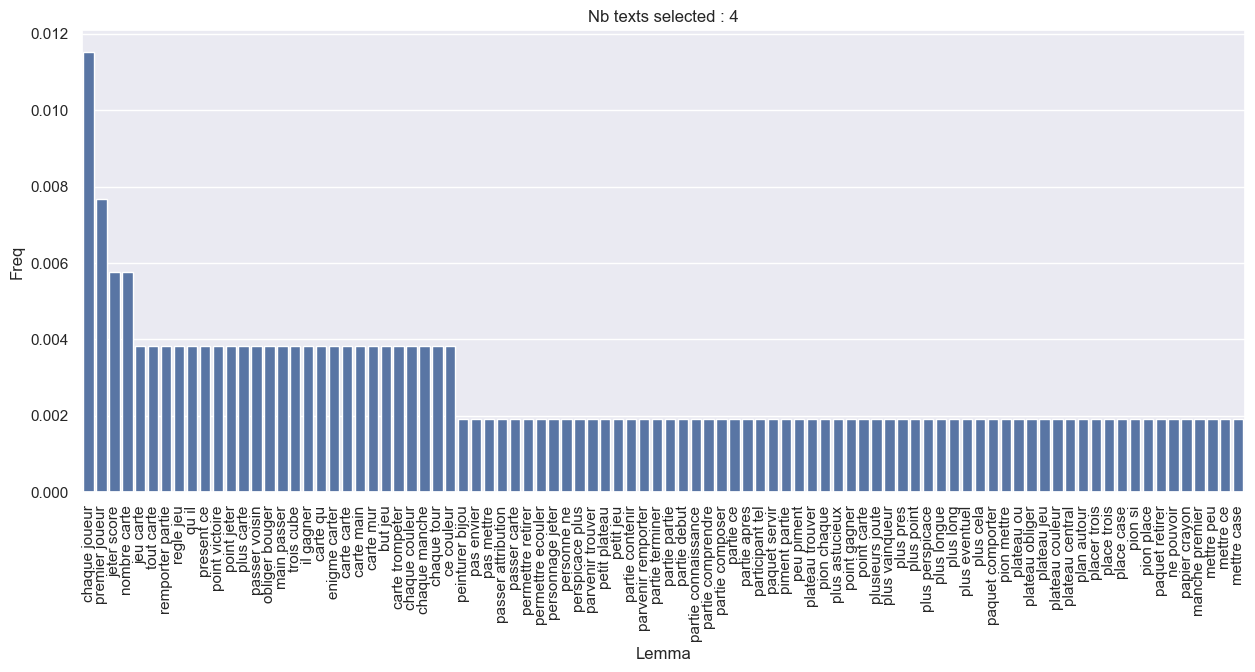

In [ ]:
desc_llm, bigrams = describe_cluster(22, 1.25, 1.25, 7, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 23 

Logique & déduction

Nb texts : 82 82
Description embeddings completed
Distance descriptions :  [0.22553461 0.22622539 0.24048499 0.24076782 0.24290684 0.24435279
 0.24545831 0.24821819 0.2488896  0.25202673]
CENTER DESC : Croître, Voyager, Récolter, Guider. Dans ce jeu de conquête et d'optimisation pour 2 à 4 joueurs,
vous incarnez un chef de tribu et tentez de faire prospérer au mieux votre peuple afin d'être le
premier à atteindre les 15 points de victoire et à l'emporter. Les dés que vous lancez se combinent
avec les choix de vos adversaires pour déterminer l'efficacité des actions. Un mode avancé est
disponible pour ceux qui auraient soif de plus d'aventures. Utilisez les pouvoirs de vos chefs de
tribu et les terrains spéciaux pour enrichir vos parties. 

Nb words: 2053
2
Nb tokens: 3187
Voici une analyse commune aux descriptions des jeux :

**Objectif** :
- Le but principal est de remporter la partie le plus rapidement possible.

**Mechaniques** :

- **Duel** : plusieurs jeux présentent un élément de

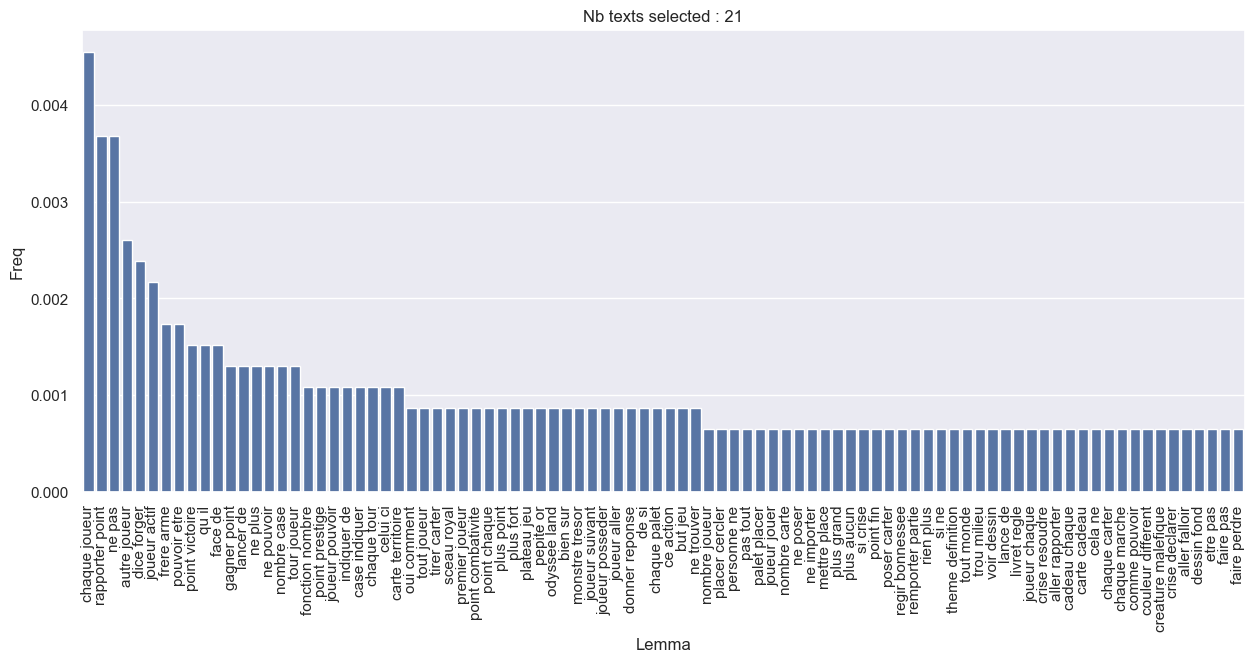

In [ ]:
desc_llm, bigrams = describe_cluster(23, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 24 (best rated)

Nb texts : 109 109
Description embeddings completed
Distance descriptions :  [0.23088382 0.23978711 0.25314933 0.25387749 0.25415248 0.25765831
 0.25784208 0.25914032 0.26019356 0.26223055]
CENTER DESC : Règle de base Chaque joueur se voit donner 7 cartes qu'il garde à sa discrétion et 5 cartes, faces
visibles, sont posées sur la table. Ces cartes représentent des "critères" qui vont du physique
(grand, petit...) aux vêtements et accessoire (boucle d'oreille, jean, etc...). Dès qu'un joueur
voit une personne avec l'un des "critères" de l'une des 5 cartes face visible, il en informe ses
adversaires et hop, il a gagné le droit de remplacer cette carte (la visible donc) par l'une de
celle qu'il a en main ! Forcément, vous l'aurez deviné, est déclaré "Grand Vainqueur" celui qui se
débarrasse de toutes ses cartes. Forcément, c'est lui qui aura trouvé le plus de personnes !
Variante dite "Total Mateur". Chaque joueur va recevoir 4 cartes "critères" qu'il garde à sa
discrétion. Puis, tous en 

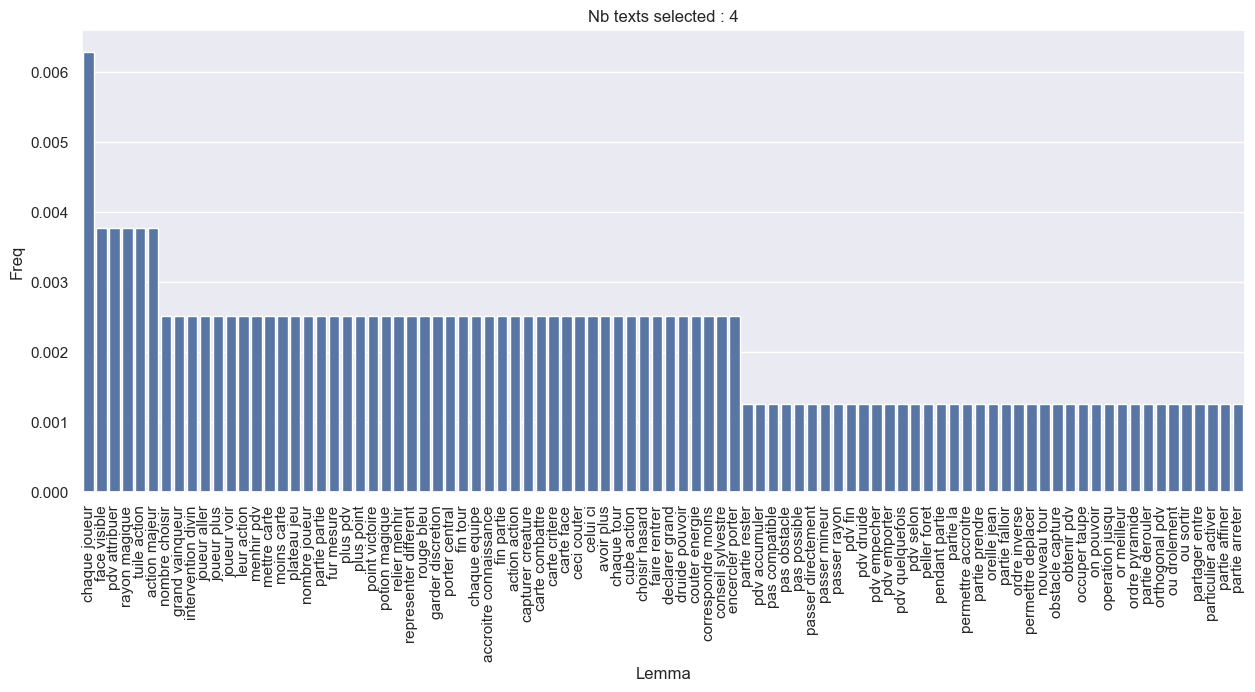

In [ ]:
desc_llm, bigrams = describe_cluster(24, 1.10, 1.10, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "desc_summary")
print(response["message"]["content"])

### Cluster 25 

Longs & complexes

Nb texts : 94 94
Description embeddings completed
Distance descriptions :  [0.63803122 0.64213639 0.65694106 0.66203574 0.66377833 0.66492944
 0.66887541 0.67134619 0.67282013 0.67361108]
CENTER DESC : But du jeu Chacun des joueurs tient le rôle d’un marchand cherchant à atteindre le plus haut niveau
social. A la fin du jeu, le marchand avec le plus haut statut est le gagnant. Les ex æquo sont
départagés par la fortune. Déroulement du jeu Le jeu se joue en plusieurs tours. Chaque tour se
décompose en 6 phases. Avant le premier tour les joueurs doivent d’abord mettre en place " la
boutique " (achat de cartes d’habileté aux enchères) Phase 1 : Achat de marchandises (0 à 3
marchandises pour chaque joueur). Phase 2 : Mise aux enchères puis chargement des chariots. Phase 3
: Mouvement des chariots et du messager Phase 4 : Modification des prix, ventes des entrepôts Phase
5 : Vente des marchandises livrées Phase 6 : Entretien et changement du statut social Fin de partie
Le jeu s’arrête lorsq

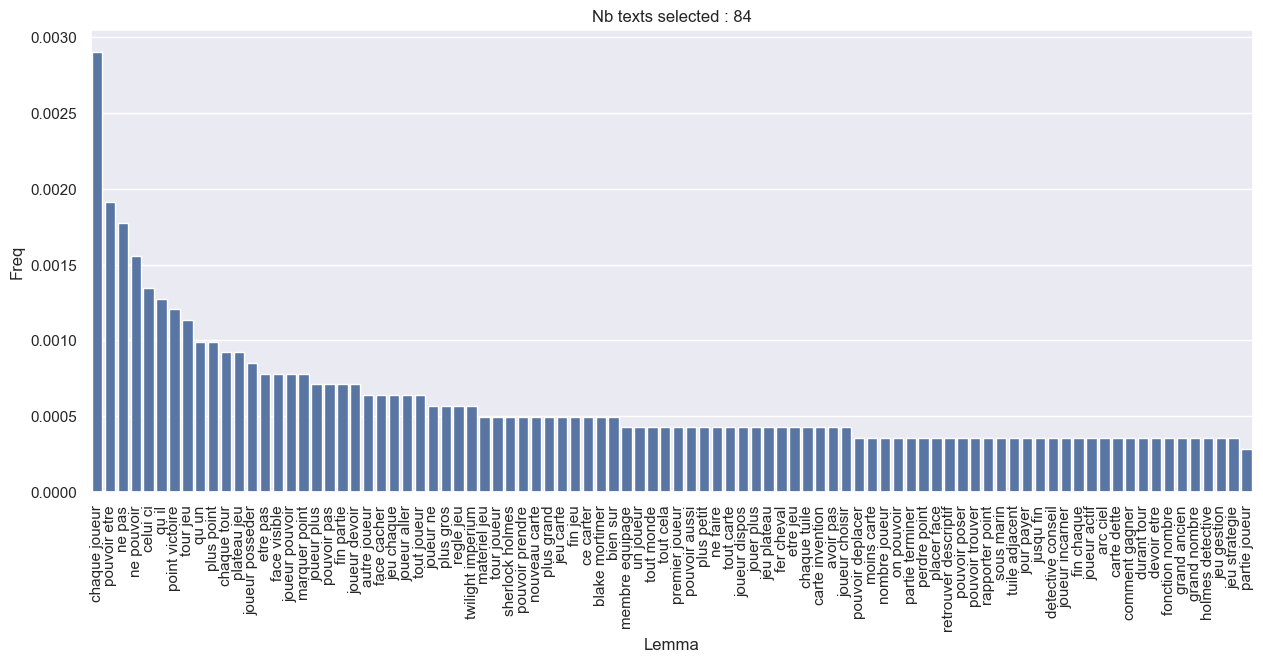

In [195]:
desc_llm, bigrams = describe_cluster(25, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
lemmas=["twilight imperium", "sherlock holmes", "blake mortimer", "carte invention", "grand ancien",
        "grand nombre", "livret regle", "jeu cooperatif", "univers warhammer", "plan carriere"]
df = pd.concat([df, bigrams[bigrams["Lemma"].isin(lemmas)]])

#bigrams.sort_values("Freq", ascending=False).iloc[0:50]
# cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
# cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

# print("Nb words:", calc_nb_words(cluster_desc["Description"]))
# response=call_model_by_batch(cluster_desc_batched, "descriptions")
# print(response["message"]["content"])

### Cluster 26 -> close to best rated cluster

Collecte

Nb texts : 96 96
Description embeddings completed
Distance descriptions :  [0.61500693 0.61959444 0.62914274 0.6327425  0.63569976 0.64204396
 0.6525634  0.65425898 0.65637826 0.6581594 ]
CENTER DESC : Sur la table sont dispersées des tuiles « monstre » faces cachées. Le but est de reconstituer un
maximum de famille de trois monstres identiques. Mais gare aux ressemblances ! Au top départ, chaque
joueur, à l’aide d’une seule main, va devoir retourner et ramasser un maximum de tuiles « monstre »
une par une. Chaque tuile ramassée est placée face cachée dans la seconde main du joueur. Attention,
une fois passée dans la seconde main du joueur, une tuile ne peut plus ni être regardée, ni être
reposée sur la table. Les erreurs vous coûteront chers puisque chaque famille incomplète ou erronée
en fin de partie vous occasionnera des points négatifs. Aux côtés des monstres sont disposées des
tuiles « trophée » faces visibles et en nombre limitées. Chaque tuile « trophée » rapporte des
points de

,Lemma,Freq
103,joueur choisir,0.000358
81,ainsi suite,0.000358
101,jouer carter,0.000358
91,des qu,0.000358
82,aller essayer,0.000358
83,bon moment,0.000358
84,carter bateau,0.000358
85,carter plus,0.000358
86,centre tabler,0.000358
88,comment gagner,0.000358


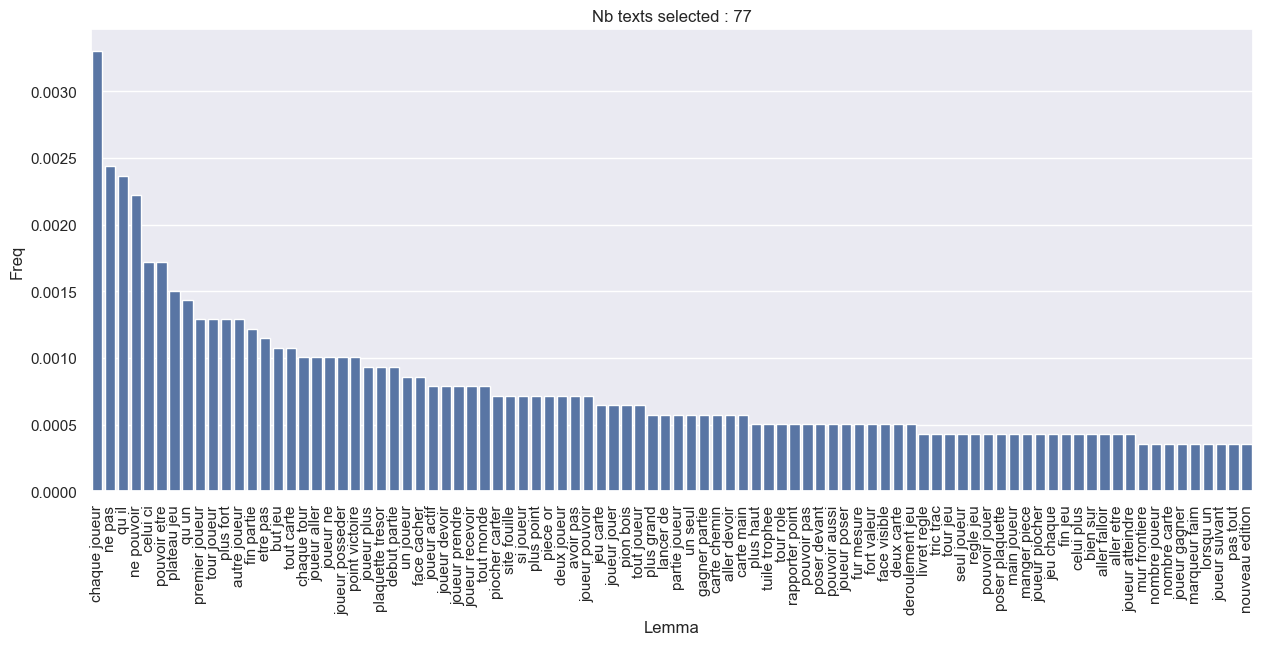

In [224]:
desc_llm, bigrams = describe_cluster(26, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
# cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
# cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

# print("Nb words:", calc_nb_words(cluster_desc["Description"]))
# response=call_model_by_batch(cluster_desc_batched, "descriptions")
# print(response["message"]["content"])
bigrams.sort_values("Freq", ascending=False).iloc[100:150]

### Cluster 27 

Capture territoire

Nb texts : 92 92
Description embeddings completed
Distance descriptions :  [0.1965556  0.19878727 0.21320339 0.21879955 0.22223321 0.22643926
 0.22725643 0.22968666 0.23152569 0.23472319]
CENTER DESC : Des pions de 5 couleurs différentes que tous les joueurs déplacent et qui leur permettent de
récolter des jetons dans les mêmes couleurs. Les dits jetons vaudront plus ou moins de points à la
fin de la partie selon la place finale des pions de la même couleur sur le parcours. 

Nb words: 2453
2
Nb tokens: 3959
Voici les résumés des descriptions des jeux en français :

1. **Les Princes d'une province chinoise** : Les joueurs incarèrent des princes et doivent gérer leur province pour accumuler des points de victoire. Ils peuvent utiliser des personnages, des évènements et des cartes d'action pour surmonter les difficultés.
 * Mécaniques clés : Gestion de la province, utilisation de personnages et d'évènement pour résoudre des problèmes
 * Target audience : Joueurs stratégiques et gérant de

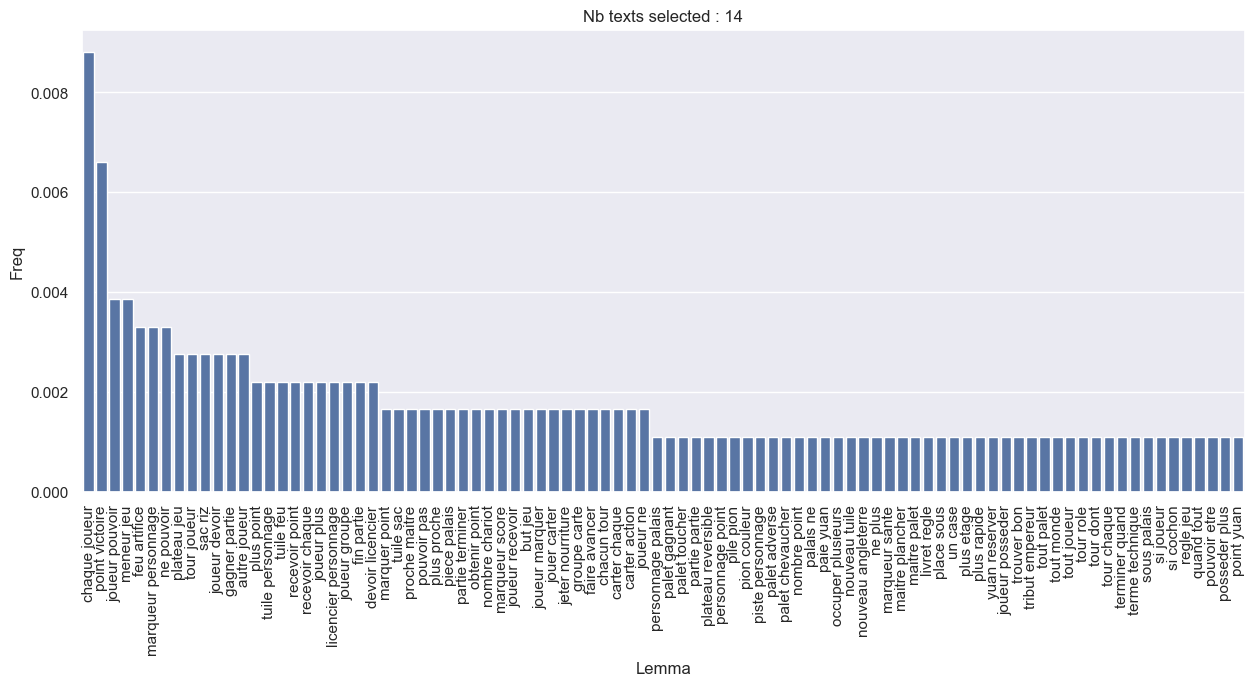

In [ ]:
desc_llm, bigrams = describe_cluster(27, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 28 

Culture | Fantaisie

Nb texts : 84 84
Description embeddings completed
Distance descriptions :  [0.20672597 0.21112341 0.21794368 0.22280393 0.22488291 0.23245551
 0.23581558 0.23716847 0.24045704 0.24126596]
CENTER DESC : Ce jeu se déroule au moyen âge où des hommes riches inspirés vont construire des tours magnifiques
afin de montrer à quel point ils prospèrent. Comme vous vous en doutez, plus la tour est grande,
plus la famille est influente car on la pense plus riche. Les joueurs sont les constructeurs de ces
tours essayant de profiter de la vanité de ces riches familles. Il vous faudra construire au bon
endroit au bon moment et jouer vos cartes à bon escient: votre nom sera deviendra alors célèbre et
sera associé à celui du plus riche et plus puissant des marchands ! ce jeu contient 149 morceaux en
bois de tour, 55 cartes de construction, 20 marqueurs de prestige et une fiche/conseil de jeu à côté
double. Principe du jeu : Chaque joueur possède trois cartes en main et doit en jouer une pendant
son tou

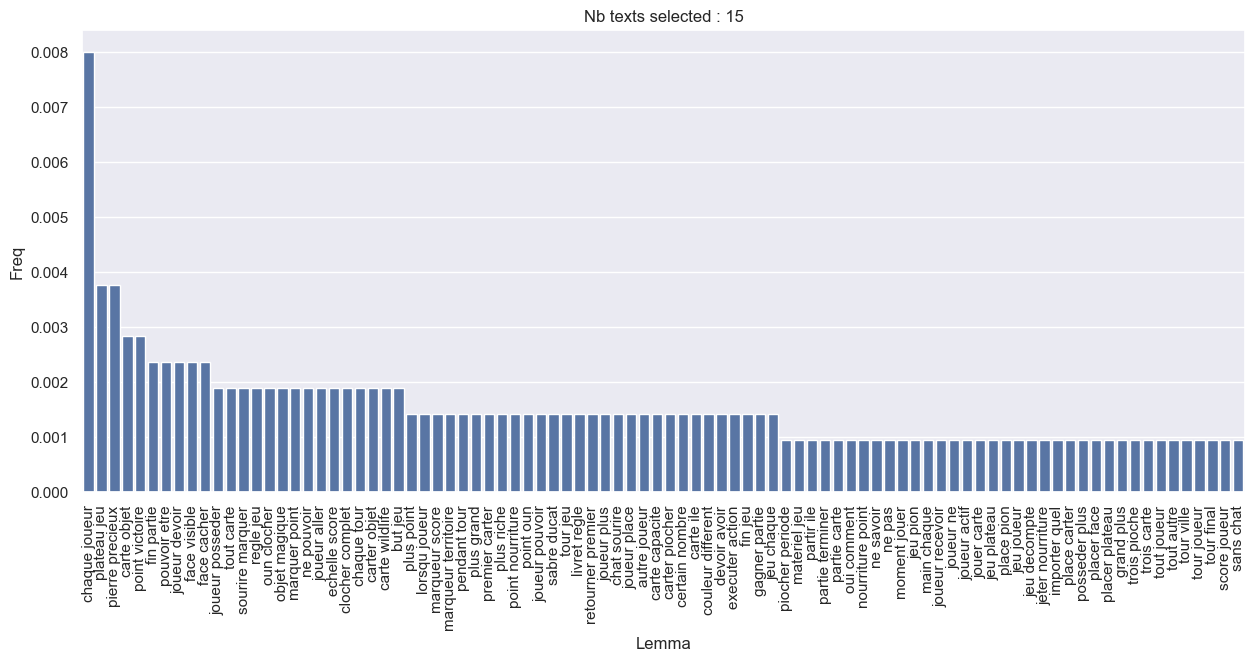

In [ ]:
desc_llm, bigrams = describe_cluster(28, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 29 

Longs & complexes


Nb texts : 96 96
Description embeddings completed
Distance descriptions :  [0.20555557 0.21050699 0.22328911 0.22769355 0.22812295 0.23088389
 0.23775505 0.23830005 0.241359   0.24304384]
CENTER DESC : Les joueurs incarnent un explorateur devant se battre contre ses compagnons pour ne pas finir
capturé par les indigènes et réussir à atteindre l'avion, seul moyen de quitter la jungle. Chaque
personnage dispose de capacités liées à son arme, avec laquelle ils peuvent charger, tirer et se
protéger. Simultanément, les joueurs miment l'action choisie et font le bruitage correspondant.
Contenu : ✔ 1 Règle de jeu ✔ 6 Aides de jeu (4 langues) ✔ 1 Plateau ✔ 6 Personnages ✔ 6 Cartes
Personnage ✔ 33 pions 

Nb words: 2535
2
Nb tokens: 4010
Je vais analyser les descriptions du jeu pour vous identifier les mécaniques clés, la cible d'audience, la complexité et autres éléments importants.

**Mécaniques clés :**

1. **Bluffing** : Les jeux qui impliquent le bluffing, tels que Saboteur, sont très popu

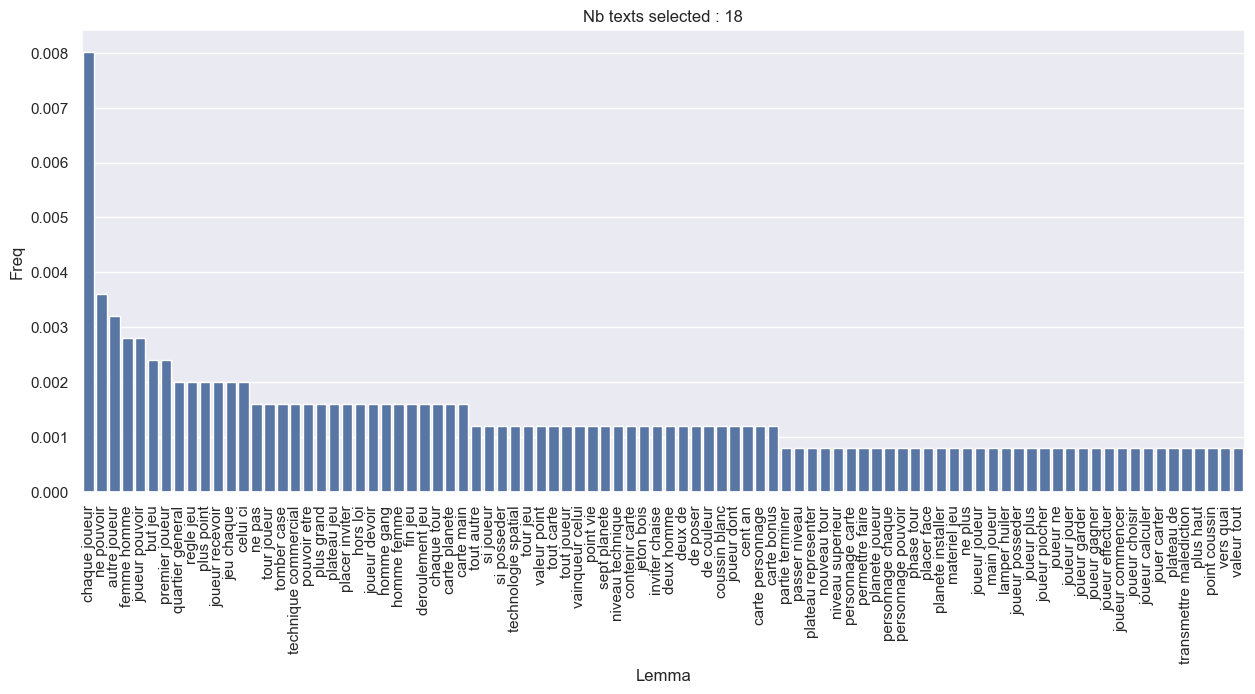

In [ ]:
desc_llm, bigrams = describe_cluster(29, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)

cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])